# Cluster-Analyse

Wendet verschiedene Cluster-Algorithmen auf die Umfragedaten an mit dem Ziel zum Schluss
"sinnvolle" (d.h. in euren Augen sinnvolle) Cluster zu bilden. Was für Cluster ergeben sich daraus
und wie wurden die Teilnehmer*innen eingeteilt? Wie musstet ihr die Daten dazu bearbeiten?

***

Vorgehen:
- Nur numerische Daten für die Analyse
- (Verworfen, aber noch im Code zuschaltbar) Zusammenfassen der Einzelsportarten zu einem sports_factor durch PCA
- Position_num rausnehmen, weil es nur drei Datenpunkte gibt, die keine Studierenden sind und das daher in unseren Augen nicht sinnvoll war, das zu berücksichtigen
- Elbow-Methode und Silhouetten-Koeffizient für die einzelnen Teilbereiche anwenden (in den meisten Fällen ergeben sich dadurch als optimale Cluster 2, 3 oder 5)
- Dimensionsreduzierung mit PCA und t-SNE für 2D Darstellung (in den meisten Fällen erkennt man hier ebenfalls 2,3, oder 5 Cluster am besten. Vor allem in tSNE mit hoher perplexity, damit die globalen Strukturen besser sichtbar werden)
- Visualisieren der Daten (ohne Sportarten, ohne Position_num) über barplots (um Cluster zu vergleichen) und Catplots (Cluster-Verteilungen besser erkennbar als in Stripplots). 
- Anwendung von RandomForestClassifier mit Cluster als Label, um zu sehen, welche features den größten Einfluss auf die Zuordnung zum Cluster hatten.
- Visualisieren anderer Kategorien außer Cluster mit PCA und tSNE (keine guten Ergebnisse erzielt)
- Hierarchical Clustering

Ergebnis:
- KMeans wurde als Cluster-Algorithmus angewendet, dessen Daten später auch in der Netzwerkanalyse verglichen werden
- In den Visualisierungen mit PCa und t-SNE waren Clusterbildungen von 2 oder 3 am besten erkennbar.
- In weiteren Cluster-Analysen wie der Nutzung von Elbow- und Silhouette-Coefficients sowie dem Hierarchical Clustering waren oft Cluster von 2, 3, 5 oder höher angegeben.
- In den Analysen der einzelnen Cluster konnten 3 Cluster am besten differenziert und erkannt werden. Daher fiel die Wahl auf 3 Cluster, da man dort aussagekräftigere Visualisierungen generieren konnte als bei höheren Cluster-Zahlen. DIe Zusammensetzung der Cluster ist unter dem Punkt "3 Cluster" beschrieben.

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb  # data visualization library  
import matplotlib.pyplot as plt  # data visualization library 

In [2]:
#Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE

In [3]:
file_name = "./data/survery_data_annonymized_230626_clean.csv"
data = pd.read_csv(file_name)
data.head(5)

#pd.show_versions()

,Alter,Geschlecht,Pseudonym,Position,Studiengang,Sportlichkeit,Sportarten,Fav_Sportart,Gesunde_Ernaehrung,Essen_gehen,...,Yoga,Kampfsport,Tanzen,Leichtathletik,Bouldern/Klettern,Schwimmen,Wassersport,Reiten,Wintersport,Rennrad/Mountainbike
0,28,männlich,lalala-lololo,Student*in,MMI,4,Basketball;Yoga;Bouldern/Klettern;Rennrad/Moun...,Joggen/Laufen,4,3,...,1,0,0,0,1,0,0,0,0,1
1,26,männlich,hbstr,Student*in,MMI,3,Fußball;Volleyball;Yoga;Bouldern/Klettern;Renn...,Fußball,4,4,...,1,0,0,0,1,0,0,0,0,1
2,24,männlich,Panda,Student*in,MMI,2,Fußball;Handball;Yoga;Tanzen;Bouldern/Klettern,Keine Angabe,5,4,...,1,0,1,0,1,0,0,0,0,0
3,23,männlich,TomTom Navigation,Student*in,MMI,5,Leichtathletik;Bouldern/Klettern;Wintersport,Trampolin,2,4,...,0,0,0,1,1,0,0,0,1,0
4,24,weiblich,LcAbrgr,Student*in,MMI,3,Bouldern/Klettern,Bouldern/Klettern,4,3,...,0,0,0,0,1,0,0,0,0,0


In [4]:
data.columns

Index(['Alter', 'Geschlecht', 'Pseudonym', 'Position', 'Studiengang',
       'Sportlichkeit', 'Sportarten', 'Fav_Sportart', 'Gesunde_Ernaehrung',
       'Essen_gehen', 'Kochen', 'Feiern', 'Fav_Essen', 'Musik', 'Fav_Musik',
       'Lesen', 'Darstellende_Kunst', 'Filme', 'Bildende_Kunst', 'Museen',
       'Videospiele', 'Soziale_Medien', 'Technologie', 'Astronomie',
       'Naturwissenschaften', 'Soziales_Engagement', 'Soziale_Gerechtigkeit',
       'Introvertiert_Extrovertiert', 'FOMO', 'Spontan', 'Verwirrt',
       'Glücklich', 'Geduldig', 'Streitlustig', 'Abenteuerlustig',
       'Studium_Zweifel', 'Studium_Zufriedenheit', 'Akademische_Laufbahn',
       'Lerngruppe', 'Prokrastination', 'Abgaben_spaet',
       'Neugier_Lebensmittel', 'Natur', 'Verreisen', 'Handwerk',
       'Sprachnachrichten', 'Wichtigkeit_Geld', 'Geschlecht_num',
       'Position_num', 'Studiengang_num', 'Basketball', 'Fußball', 'Handball',
       'Football', 'Hockey', 'Volleyball', 'Tennis', 'Yoga', 'Kampfsport',
  

In [5]:
#Sportarten_Liste ohne Floorball
sportarten_list = ["Basketball",
              "Fußball",
              "Handball",
              "Football",
              "Hockey",
              "Volleyball",
              "Tennis",
              "Yoga",
              "Kampfsport",
              "Tanzen",
              "Leichtathletik",
              "Bouldern/Klettern",
              "Schwimmen",
              "Wassersport",
              "Reiten",
              "Wintersport",
              "Rennrad/Mountainbike"]

## Aufteilung in Kategorien

Zusätzl. Daten
- Alter
- ~Geschlecht~ (nicht numerisch)
- Geschlecht_num
- ~Pseudonym~ (nicht numerisch)
- ~Position~ (nicht numerisch)
- Position_num
- ~Studiengang~ (nicht numerisch)
- Studiengang_num

Sport
- Sportlichkeit
- ~Sportarten~ (wurden übersetzt in Num)
- sportarten_list
- ~Fav_Sportart~ (nur für NLP)

Ernährung/ Lifestyle
- Gesunde_Ernaehrung
- Essen_gehen
- Kochen
- Feiern
- ~Fav_Essen~ (nur für NLP)
- Neugier_Lebensmittel
- Natur
- Verreisen

Kultur
- Musik
- ~Fav_Musik~ (nur für NLP)
- Lesen
- Darstellende_Kunst
- Filme
- Bildende_Kunst
- Museen
- Handwerk

Technologie/Wissenschaft
- Videospiele
- Soziale_Medien
- Technologie
- Astronomie
- Naturwissenschaften

Sozial
- Soziales_Engagement
- Soziale_Gerechtigkeit
- Introvertiert_Extrovertiert
- FOMO
- Spontan
- Verwirrt
- Glücklich
- Geduldig
- Streitlustig
- Abenteuerlustig
- Sprachnachrichten

Studium/ Karriere
- Studium_Zweifel
- Studium_Zufriedenheit
- Akademische_Laufbahn
- Lerngruppe
- Prokrastination
- Abgaben_spaet
- Wichtigkeit_Geld

In [6]:
#VORBEREITUNG KATEGORIEN

# all data
# Creating a copy of data (with only numerical values, so ignore non-numerical values from above)
data_num = data.copy().select_dtypes(include='number')

data_num_without_sports = data.copy().select_dtypes(include='number')
data_num_without_sports = data_num_without_sports.drop(columns=sportarten_list, axis=1)

# cleaning
#Die rauslassen, weil es einfach so wenige Unterschiede in den Daten gibt 
columns_position_num = ['Position_num']

data_num.drop(columns=columns_position_num, axis=1)
data_num_without_sports.drop(columns=columns_position_num, axis=1,inplace=True)


#COLUMNS CATEGORIES
# general data
columns_age = ['Alter']

columns_sex_num = ['Geschlecht_num']

columns_studiengang_num = ['Studiengang_num']


# sports
columns_sports = ['Sportlichkeit'] 
columns_sports.extend(sportarten_list)


# ernaehrung_lifestyle
columns_lifestyle = ['Gesunde_Ernaehrung', 
                     'Essen_gehen', 
                     'Kochen', 
                     'Neugier_Lebensmittel', 
                     'Feiern', 
                     'Natur', 
                     'Verreisen'
                    ] 

# kultur
columns_kultur = ['Musik', 
                  'Lesen', 
                  'Darstellende_Kunst', 
                  'Filme', 
                  'Bildende_Kunst', 
                  'Museen',
                  'Handwerk']

 
# technology
columns_tech_sci = ['Videospiele', 
                    'Soziale_Medien', 
                    'Technologie', 
                    'Astronomie', 
                    'Naturwissenschaften']


#sozial
columns_social = ['Soziales_Engagement', 
                  'Soziale_Gerechtigkeit', 
                  'Introvertiert_Extrovertiert', 
                  'FOMO', 
                  'Sprachnachrichten']
 
columns_personality = ['Spontan', 
                       'Verwirrt', 
                       'Glücklich', 
                       'Geduldig',
                      'Streitlustig', 
                      'Abenteuerlustig']


#studium/karriere
columns_studium = ['Studium_Zweifel', 
                   'Studium_Zufriedenheit', 
                   'Akademische_Laufbahn', 
                   'Lerngruppe', 
                   'Prokrastination', 
                   'Abgaben_spaet',
                   'Wichtigkeit_Geld',]


# Clustering
## K-Means

In [7]:
# allgemein Variablen
kmeans_kwargs = {
    "init": "k-means++", # chooses good seeds
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0}

In [8]:
# scaling and fitting
# Scaling: hier werden die numerischen Werte umgerechnet, 
# weil wir viele absolute Werte haben die sehr unterschiedliche Bandbreiten haben
# wenn wir dann mit einem clustering-Algorithmus nach Nähe suchen, hätte das bei absoluten Werten
#Ausirkungen, weil alle Werte gleich behandelt werden und dadurch das Clustering stark verzerrt wird
# deshalb rechnen wir alle Werte runter auf eine Gauss-Verteilung, dass der Mittelwert immer bei 0 liegt

#ALL numerical columns
scaler_all = StandardScaler()
scaler_all.fit(data_num)
data_all_scaled = pd.DataFrame(scaler_all.transform(data_num),
                           columns= data_num.columns )

#numerical columns without sports
scaler_all_without_sports = StandardScaler()
scaler_all_without_sports.fit(data_num_without_sports)
data_all_without_sports_scaled = pd.DataFrame(scaler_all_without_sports.transform(data_num_without_sports),
                           columns= data_num_without_sports.columns )

In [9]:
#elbow method to find best cluster-value
# A list holds the SSE values for each k
def elbow_method(data, label):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE " + label)
    plt.show()
    
    return sse


In [10]:
# silhouette score
# A list holds the silhouette coefficients for each k
def silhouette_score_method(data, label):
    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 11):
        kmeans_all = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans_all.fit(data)
        score_all = silhouette_score(data, kmeans_all.labels_)
        silhouette_coefficients.append(score_all)
        

    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient " + label)
    plt.show()
    
    return silhouette_coefficients

In [11]:
def elbow_and_silhouette(data, label):
    return elbow_method(data, label), silhouette_score_method(data, label)

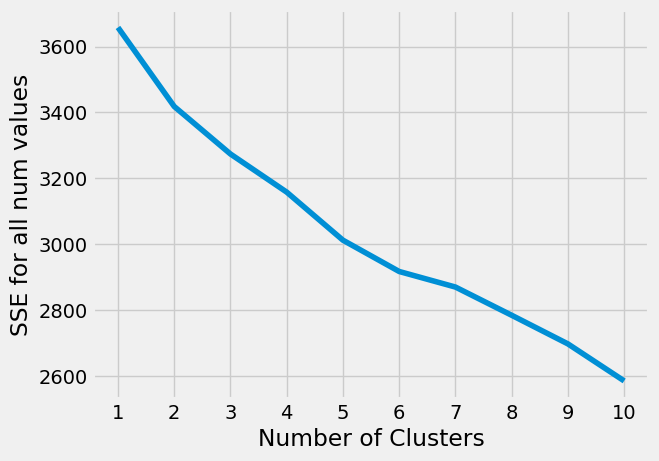

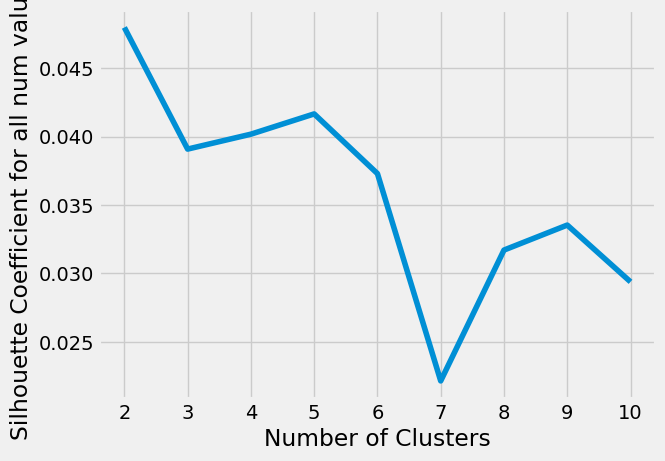

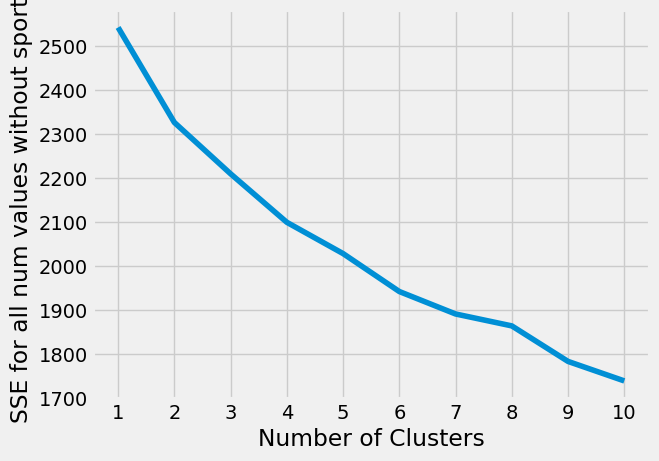

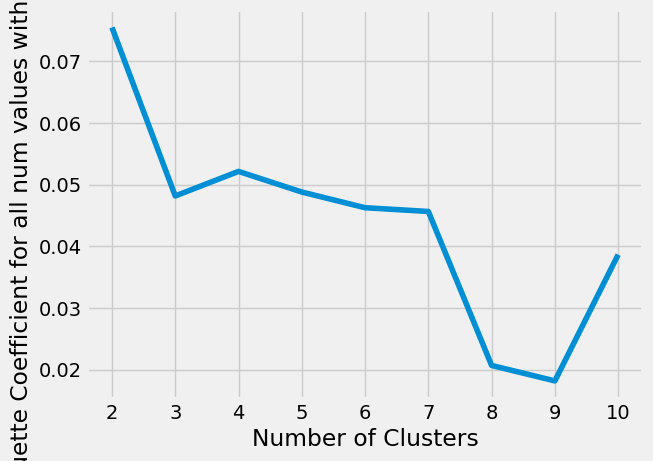

([2542.0,
  2326.428096148116,
  2209.9150455424774,
  2099.85757383272,
  2028.845944269499,
  1942.7419436676573,
  1891.8010768003414,
  1864.7423055567801,
  1784.1278267535872,
  1739.8925700711802],
 [0.07550802859646524,
  0.04817739744714839,
  0.052156708875401185,
  0.04881310201178609,
  0.04626883688240476,
  0.04565878397873471,
  0.020682400978042987,
  0.01817578949578666,
  0.038660209326860734])

In [12]:
label_all= "for all num values"
elbow_and_silhouette(data_all_scaled, label_all)
# die Methoden für alle Daten suggesten, dass 2 oder 5 Cluster am meisten Sinn machen

label_all_without_sports = "for all num values without sports"
elbow_and_silhouette(data_all_without_sports_scaled, label_all_without_sports)
# die Methoden für alle Daten ohne die Sportarten suggesten, dass 2 oder 6 Cluster am meisten Sinn machen


### Optional: sports_factor

Hier wurde getestet, den sports_factor ins Clustering mit einzubeziehen, der die Angaben zu Sportarten durch PCA zusammenfasst.

Die Gedanke war, dass einzelne Sportarten wie zum Beispiel Basketball, Yoga, Kampfsport großen Einfluss auf das Cllustering ausgeübt haben, obwohl sie zu großen Teilen nur Nullen beinhalten. Das ließ uns vermuten, dass es sich um Noise mit wenig Aussagekraft pro einzelner Kategorie handelt und es zu Overfitting führen könnte. Daher wurden die Sport-Dimensionen testweise mittels PCA auf eine Dimension zusammengeführt (sports_factor), der stattdessen im Dataset mit verwendet wird.

Dieser sports_factor ist im momentanen Datensatz und den Clustern nicht vorhanden, da er wenig Aussagekraft beinhaltet. Soll er wieder eingesetzt werden, kann der folgende Code einkommentiert werden. Dann wird er in allen folgenden Berechnungen mit einbezogen. In der Netzwerkanalyse kann verglichen werden, wie sich der Aufbau des Graphs verändert, wenn der sports_factor auf das Clustering einwirkt.

In [58]:
#PCA auf die Sportarten

#sportarten = data.copy()[sportarten_list]

#pca = PCA(n_components=1)
#X_pca = pca.fit_transform(sportarten) # fit_transform lernt und wandelt sofort danach um

#data with sports factor
data_num_wsf= data_num_without_sports.copy()
#data_num_wsf['sports_factor'] = X_pca

scaler_wsf = StandardScaler()
scaler_wsf.fit(data_num_wsf)
data_num_wsf_scaled = pd.DataFrame(scaler_wsf.transform(data_num_wsf),
                          columns= data_num_wsf.columns )

data_num_wsf_scaled

,Alter,Sportlichkeit,Gesunde_Ernaehrung,Essen_gehen,Kochen,Feiern,Musik,Lesen,Darstellende_Kunst,Filme,...,Prokrastination,Abgaben_spaet,Neugier_Lebensmittel,Natur,Verreisen,Handwerk,Sprachnachrichten,Wichtigkeit_Geld,Geschlecht_num,Studiengang_num
0,0.555073,0.728893,0.552967,-0.871197,0.181800,0.153296,1.071517,0.727409,0.314127,-0.827253,...,-0.621966,-1.228279,1.041785,2.050392,-1.0,-0.945274,0.287883,-0.375639,0.639602,1.064933
1,0.105210,-0.298183,0.552967,0.147939,1.206488,-0.710737,0.000000,-0.912567,0.314127,0.287740,...,-1.540107,-1.228279,0.016536,-0.104257,0.0,0.886194,0.287883,0.636952,0.639602,1.064933
2,-0.344653,-1.325259,1.777393,0.147939,0.181800,0.153296,1.071517,-0.912567,0.314127,0.287740,...,1.214315,-2.103605,-1.008712,-1.181582,0.0,-0.945274,1.099190,-0.375639,0.639602,1.064933
3,-0.569585,1.755968,-1.895886,0.147939,0.181800,-0.710737,-1.071517,-0.092579,-0.532650,0.287740,...,-1.540107,-0.352954,1.041785,0.973067,1.0,-0.945274,0.287883,-0.375639,0.639602,1.064933
4,-0.344653,-0.298183,0.552967,-0.871197,-1.867577,-1.574770,-1.071517,0.727409,-0.532650,1.402733,...,1.214315,1.397697,-2.033961,-0.104257,1.0,-0.029540,0.287883,0.636952,-1.563472,1.064933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.105210,-2.352335,0.552967,0.147939,1.206488,-0.710737,1.071517,-0.092579,1.160903,1.402733,...,-1.540107,-2.103605,0.016536,-0.104257,-1.0,-0.029540,-1.334731,-0.375639,0.639602,1.064933
58,-0.794517,-0.298183,-0.671460,0.147939,0.181800,0.153296,0.000000,-1.732556,-1.379426,-1.942245,...,0.296174,-0.352954,0.016536,-0.104257,1.0,0.886194,-1.334731,1.649543,0.639602,0.134992
59,-0.119722,-0.298183,-0.671460,0.147939,-0.842889,-0.710737,0.000000,0.727409,0.314127,-0.827253,...,0.296174,0.522372,0.016536,2.050392,0.0,0.886194,-0.523424,-1.388229,-1.563472,0.134992
60,1.229868,-0.298183,0.552967,1.167075,1.206488,0.153296,1.071517,0.727409,1.160903,1.402733,...,-0.621966,-1.228279,1.041785,0.973067,1.0,-0.029540,-0.523424,-0.375639,-1.563472,-1.724892


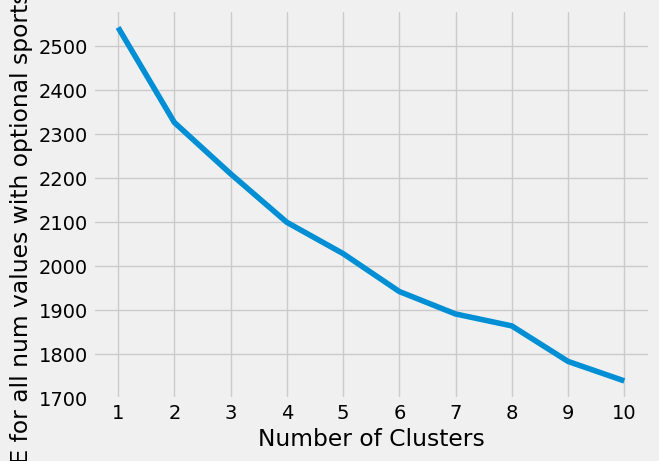

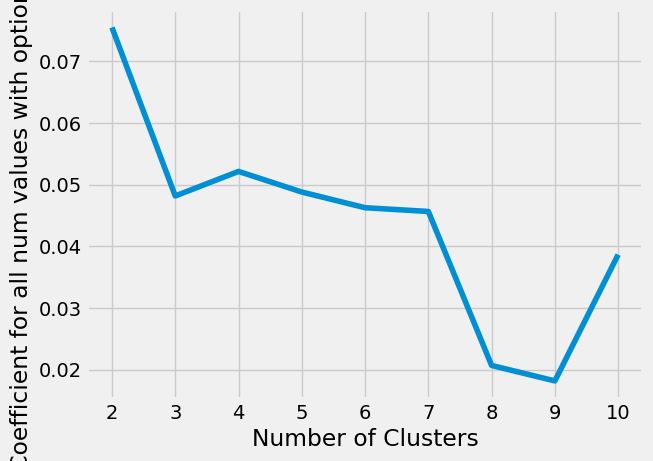

([2542.0,
  2326.428096148116,
  2209.9150455424774,
  2099.85757383272,
  2028.845944269499,
  1942.7419436676573,
  1891.8010768003414,
  1864.7423055567801,
  1784.1278267535872,
  1739.8925700711802],
 [0.07550802859646524,
  0.04817739744714839,
  0.052156708875401185,
  0.04881310201178609,
  0.04626883688240476,
  0.04565878397873471,
  0.020682400978042987,
  0.01817578949578666,
  0.038660209326860734])

In [61]:
label_all_wsf = "for all num values with optional sports factor"

elbow_and_silhouette(data_num_wsf_scaled, label_all_wsf)
# die Methoden suggesten, dass 2, 3, 4 oder 6 Cluster am meisten Sinn machen

### 2D-Visualisierung: PCA und t-SNE

MDS wurde ebenfalls getestet, wurde aber verworfen, da die Visualisierung keine neuen Erkenntnisse gebracht hat.

#### Aufgabenstellung:
**Nutzt verschiedene Techniken der Dimensionsreduzierung um alle Teilnehmer\*innen der Umfrage in einem 2D-Scatterplot darzustellen.**
Genutzt wurden 
- PCA
- t-SNE

**Diskutiert das Resultat, auch im Bezug auf die Cluster-Analyse.**
- Wie zu Anfang erklärt, konnten die Visualisierungen dabei unterstützen, eine sinnvolle Anzahl an Clustern zu identifizieren.
- Vor allem t-SNE konnte Strukturen von 2 bis 4 Clustern gut sichtbar machen, weil Muster/ Unterschiede erst mit Fokus auf globale Strukturen gut erkennbar waren
- Dimensionsreduzierung wurde zudem betrieben im Bezug auf Daten mit zu großem Bias (Position_num, Sportarten)

**Färbt die Punkte nach den zuvor berechneten Clustern oder nach bestimmten Merkmalen (Alter, Antwort auf spezielle Fragen...) ein und diskutiert ob die Dimensionsreduzierung erfolgreich/nützlich war.**
Für die Cluster-Analyse und die Visualisierung der Cluster war die Dimensionsreduzierung nützlich, nicht allerdings für die Darstellung anderer Features. Vor allem bei der Festlegung der Anzahl der Cluster hat uns die Dimensionsreduzierung und die 2D-Visualisierung geholfen. Der Versuch, die Sport-Dimensionen auf einen Faktor zu reduzieren, wurde als nicht erfolgreich/ zielführend bewertet und daher nicht in das Endergebnis mit einbezogen. 

In [62]:
def dimension_reduction(data_scaled, clusters, tsne_perplexity):
    kmeans_test_all = KMeans(n_clusters=clusters, **kmeans_kwargs)
    cluster_labels = kmeans_test_all.fit_predict(data_scaled)

    # Evaluate clusters
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")

    #PCA
    pca_test_all = PCA(n_components=2)
    pca_result_test_all = pca_test_all.fit_transform(data_scaled)

    #TSNE
    tsne_test_all = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=300, random_state=0)
    tsne_result_test_all = tsne_test_all.fit_transform(data_scaled)

    #plot both
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sb.scatterplot(x=pca_result_test_all[:, 0], y=pca_result_test_all[:, 1], hue=cluster_labels, palette="Set1")
    plt.title('PCA Visualization')

    plt.subplot(1, 2, 2)
    sb.scatterplot(x=tsne_result_test_all[:, 0], y=tsne_result_test_all[:, 1], hue=cluster_labels, palette="Set1")
    plt.title('t-SNE Visualization')

    plt.tight_layout()
    plt.show()

In [63]:
#2 oder 5 für alle skalierten daten
#2 am besten erkennbar
#dimension_reduction(data_all_scaled, 2, 50)


#2 oder 6 für alle skalierten daten ohne Sport
#2, 3 und 5 am besten erkennbar
#dimension_reduction(data_all_without_sports_scaled, 2, 50)

Silhouette Score: 0.07550802859646524


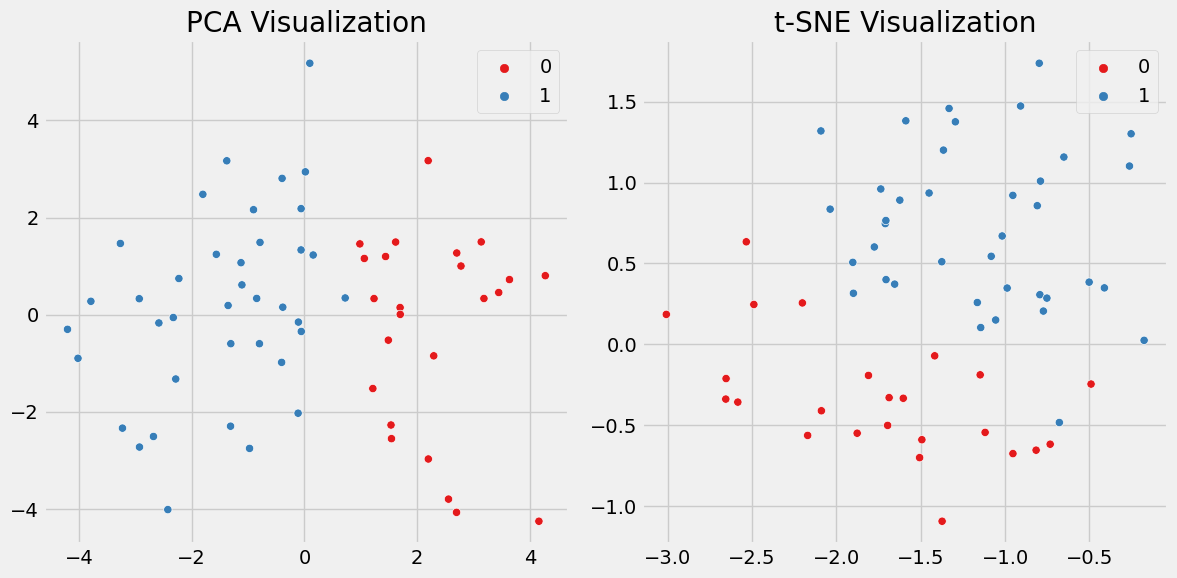

Silhouette Score: 0.04817739744714839


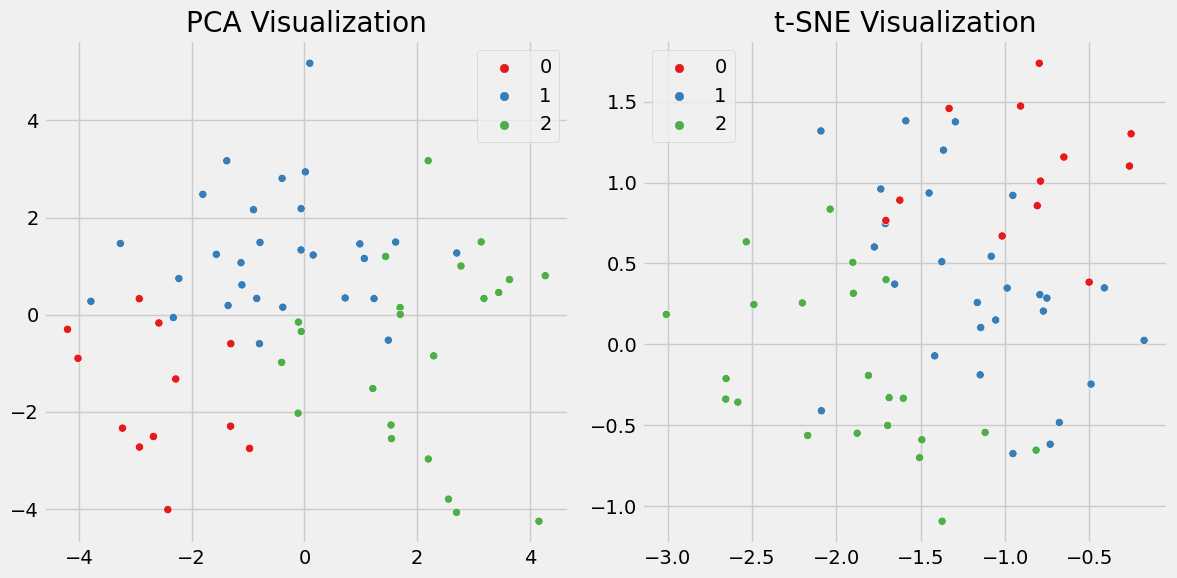

In [18]:
#2 oder 5 für die skalierten daten mit sports factor
#2,3, und 5 cluster sind am besten erkennbar
dimension_reduction(data_num_wsf_scaled, 2, 45)
dimension_reduction(data_num_wsf_scaled, 3, 45)
#dimension_reduction(data_num_wsf_scaled, 5, 45)

## Einfärben der Ergebnisse für andere Parameter außer Cluster

Getestet wurden vor allem die Parameter, die in verschiedenen Fällen am meisten zur Clusterbildung beigetragen haben.
- Darstellende_Kunst
- Introvertiert_Extrovertiert
- Naturwissenschaften

Sowie die numerischen Repräsentationen von Geschlecht udn Studiengang
- Geschlecht_num
- Studiengang_num

Durch die Einfärbung konnten keine weiterne Erkenntnisse gewonnen werden. Im Gegensatz zu den Clustern lassen sich hier kaum Zusammenhänge oder interessante Gruppenbildungen erkennen. Daher wurde dieser Ansatz nicht weiterverfolgt.

In [64]:
# Perform clustering
def dimension_reduction_colorize(data_scaled, tsne_perplexity, hue_name):

    #PCA
    pca_test_all = PCA(n_components=2)
    pca_result_test_all = pca_test_all.fit_transform(data_scaled)

    #TSNE
    tsne_test_all = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=300, random_state=0)
    tsne_result_test_all = tsne_test_all.fit_transform(data_scaled)

    #plot both
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sb.scatterplot(x=pca_result_test_all[:, 0], y=pca_result_test_all[:, 1], hue=hue_name, palette="Set1")
    plt.title('PCA Visualization')

    plt.subplot(1, 2, 2)
    sb.scatterplot(x=tsne_result_test_all[:, 0], y=tsne_result_test_all[:, 1], hue=hue_name, palette="Set1")
    plt.title('t-SNE Visualization')

    plt.tight_layout()
    plt.show()

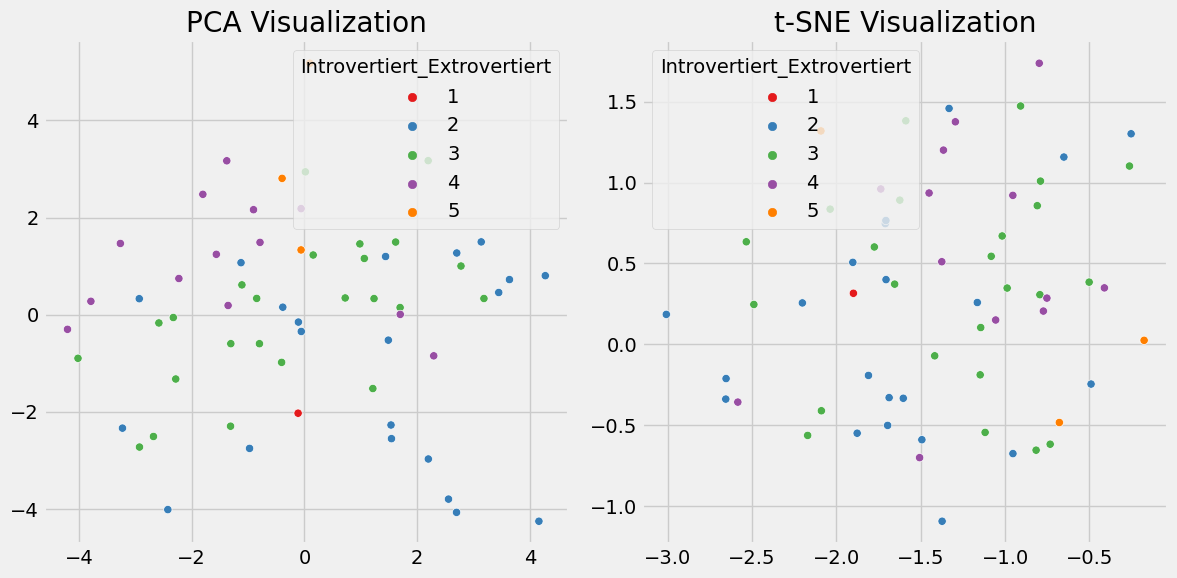

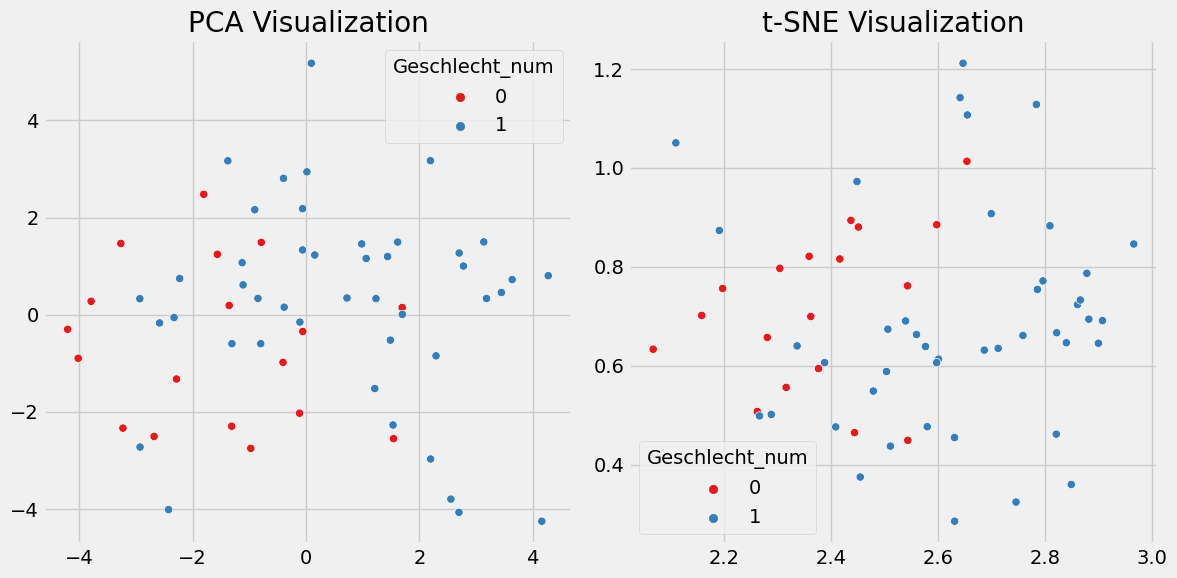

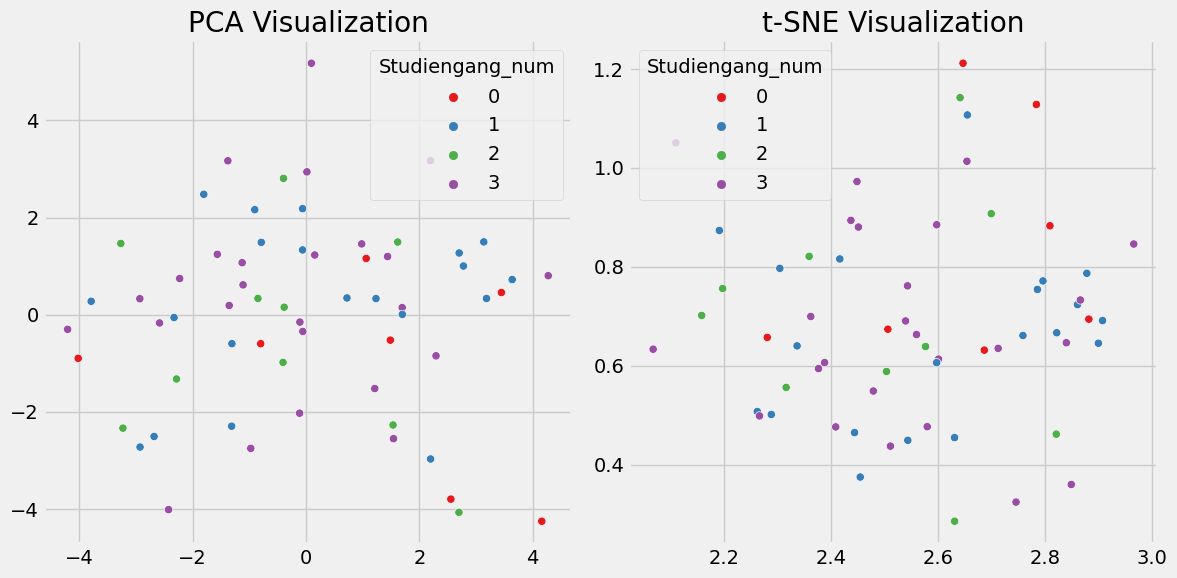

In [20]:
dimension_reduction_colorize(data_num_wsf_scaled, 45, data['Introvertiert_Extrovertiert'])
#dimension_reduction_colorize(data_num_wsf_scaled, 49, data['Darstellende_Kunst'])
#dimension_reduction_colorize(data_num_wsf_scaled, 45, data['Naturwissenschaften'])
dimension_reduction_colorize(data_num_wsf_scaled, 60, data['Geschlecht_num'])
dimension_reduction_colorize(data_num_wsf_scaled, 60, data['Studiengang_num'])

# Cluster-Analysis alle Werte

## Funktionen

In [21]:
def draw_stripplot(data, x, y, hue):
    ax = sb.stripplot(data = data,
                        x=x,
                        y=y,
                        hue=hue,
                        palette="Set1")
    plt.legend()
    plt.show()

In [22]:
def draw_catplot(data, x, y, cluster):
    ax = sb.catplot(data = data,
                    x=x,
                    y=y,
                    hue=cluster,
                    palette="Set1", 
                    col=cluster)
    plt.legend()
    plt.show()

In [23]:
def check_clustering(category_list, 
                     clusters=3, 
                     show_stripplot=False, 
                     show_catplot=False, 
                     show_cluster_bars=False, 
                     show_pairplot=False,
                    pairplot_vars=[]):
    for data_category in category_list:
        #Index von columns der Kategorie
        category_columns_temp = data_category.columns
        
        scaler_temp = StandardScaler()
        scaler_temp.fit(data_category)
        #skalierte Daten
        data_temp_scaled = pd.DataFrame(scaler_temp.transform(data_category),
                                   columns= data_category.columns )
        

        #anwenden, cluster als Vorgabe
        kmeans_temp = KMeans(n_clusters=clusters, **kmeans_kwargs).fit(data_temp_scaled) 
        #Cluster-Label
        kmeans_temp.labels_

        # in die tabelle übernehmen
        data_temp_clustered = data_category.copy()
        data_temp_clustered["cluster_"+str(clusters)+"_temp"] = kmeans_temp.labels_
        #print(data_temp_clustered.head())

        if(show_stripplot):
            for index in range(0, (len(category_columns_temp))):
                for index_j in range(0, (len(category_columns_temp))):
                    ax = sb.stripplot(data = data_temp_clustered,
                                        x=category_columns_temp[index_j],
                                        y=category_columns_temp[index],
                                        hue="cluster_"+str(clusters)+"_temp",
                                        palette="Set1")
                    #ax.set_title(category_columns_temp[index_j] + " und " + category_columns_temp[index])
                    plt.legend()
                    plt.show()
        
        if(show_catplot):
            for index in range(0, (len(category_columns_temp))):
                for index_j in range(0, (len(category_columns_temp))):
                    ax = sb.catplot(data = data_temp_clustered,
                                    x=category_columns_temp[index_j],
                                    y=category_columns_temp[index],
                                    hue="cluster_"+str(clusters)+"_temp",
                                    palette="Set1", 
                               col="cluster_"+str(clusters)+"_temp")
                    #ax.set_title(category_columns_temp[index_j] + " und " + category_columns_temp[index])
                    plt.legend()
                    plt.show()

        if(show_cluster_bars):
            for index in range(0, (len(category_columns_temp))):
                sb.barplot(x="cluster_"+str(clusters)+"_temp",y=category_columns_temp[index], data=data_temp_clustered, palette="Set1")
                plt.title(category_columns_temp[index] + " / Cluster")
                plt.show()
        
        if(show_pairplot):
            sb.pairplot(data,
                        hue="cluster_"+str(clusters)+"_temp",
                        vars=pairplot_vars)


In [24]:
def scaling_and_clustering(data, clusters=3):
    scaler_temp = StandardScaler()
    scaler_temp.fit(data)
    data_temp_scaled = pd.DataFrame(scaler_temp.transform(data),
                               columns= data.columns )

    #anwenden, cluster als Vorgabe
    kmeans_temp = KMeans(n_clusters=clusters, **kmeans_kwargs).fit(data_temp_scaled) 
    kmeans_temp.labels_

    cluster_column_name = "cluster_"+str(clusters)+"_temp"
    # in die tabelle übernehmen
    data_temp_clustered = data.copy()
    data_temp_clustered[cluster_column_name] = kmeans_temp.labels_
    return data_temp_clustered, cluster_column_name


#Das hier ist nur interessant, wenn man ein label bereitstellt. In dem Fall ist das das cluster, 
# um zu sehen, was am meisten Einfluss auf das Clustering hatte. 
# Für unsupervised learning ist der hier nicht geeignet.
def feature_selection(data, label_column, threshold): 
    y = data[label_column]
    X = data.drop(label_column, axis=1)
    
    #Feature Selection
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                        random_state=0)

    rfclf = RandomForestClassifier(max_depth=3, random_state=42)
    rfclf.fit(X_train, y_train)

    
    # Visualizing feature importances

    feature_imp = pd.Series(rfclf.feature_importances_, 
                            index=data.columns.drop(label_column)).sort_values(ascending=False)
    
    columns_to_drop = feature_imp[feature_imp < threshold].index

    plt.figure(figsize=(25, 20))
    print(sb.barplot(x=feature_imp, y=feature_imp.index))
    plt.xlabel('Feature Importance Score ' + label_column, fontsize=20)
    plt.ylabel('Features', fontsize=20)
    plt.title("Visualizing Important Features", fontsize=20, pad=20)
    
    return columns_to_drop

## 3 Cluster

Am besten wurden 2.3 oder 5 Cluster bewertet. Hier werden alle drei getestet.

HINWEIS: Spoiler. Die 3 CLuster wurden als am besten darstelll- und interpretierbar bewertet und sind daher die Cluster der Wahl bei weiteren Darstellungen. Es folgen die auskommentiertne Tests für 2 und 5.

- Rot ist am ältesten (breitere Streuung), Blau mittel (25), Grün < 25
- Rot ist am unsportlichsten (< 2.5), Grün am sportlichsten (Grün und Blau kein großer Unterschied)
- Rot legt am wenigsten Wert auf gesunde Ernährung (breiteste Streuung), Blau am meisten (kein großer Unterschied zwischen grün und Blau)
- Rot geht am liebsten Essen (>4), kein großer Unterschied zwischen Rot und Blau, Grün am wenigsten (< 3.5)
- Grün kocht am wenigsten gerne, breite Streuungen, wenig Unterschiede zwischen Rot und Blau
- Rot geht am liebsten Feiern (größere Streuung), wenig Unterschied zu Blau, Grün am wenigsten (große Streuung)
- Rot mag Musik am meisten, Grün am wenigsten
- Rot mag Lesen am meisten, Blau am wenigsten
- Rot mag darstellende Kunst am meisten (> 4.0), Blau (2.5) und Grün (2.1) weniger
- Rot schaut am liebsten Filme, keine großen Unterschiede
- Rot mag Bildende Kunst am meisten (> 4.0), Blau (3.0) mittel, Grün am wenigsten (<2.5, größere Streuung)
- Rot mag Museen am meisten (> 4.0), Grün und Blau weniger (< 3.0)
- Bei Videospielen große Streuung und wenig Unterschiede
- Blau nutzt soziale Medien am liebsten (> 4.0), Rot am wenigsten (< 3.0, breite Streuung)
- Rot mag Technologie am meisten (4.5), Grün am wenigsten (< 4.0)
- Astronomie hat breite Streuung und wenig Unterschiede)
- Rot mag Naturwissenschaften am meisten (3.5, große Streuung), Grün am wenigsten (2.5)
- Rot ist soziales Engagement und soziale Gerechtigkeit am wichtigsten (wenig Unterscheid zu Blau, große Streuung), Grün am wenigsten
- Blau ist am extrovertiertesten (3.4), Rot (2.7) mittel, Grün (2.4) am introvertiertesten
- Blau hat am meisten Fomo, Rot hat große Streuung, Grün hat das am wenigsten
- Blau ist am spontansten, Rot mittel (große Streuung), Grün am wenigsten (keine großen Unterschiede zu Rot)
- keine großen Unterschiede bei Verwirrtheit
- Grün ist am wenigsten glücklich (ca. 3.4), Rot und Blau keine großen Unterschiede (> 4.0)
- Rot ist am geduldigsten, Blau am wenigsten geduldig
- Blau sit am streitlustigsten (> 2.0), Rot am wenigsten (< 1.5)
- Blau ist am abenteuerlustigsten, wenig Unterschied zu Rot, Grün am wenigsten
- Studienzweifel haben große Streuung und wenig Unterschied, Rot hat im Mittel die wenigsten
- Studienzufriedenheit ist bei Rot und Blau ähnlich (knapp an 4.0), Grün hat am wenigsten (< 3.5)
- Rot strebt am meisten eine akademische LAufbahn an (>3.0, große Streuung), Grün am wenigsten (< 2.5)
- Blau lernt am liebsten in einer LErngruppe, Grün am wenigsten (wenig Unterschied zwischen Grün und Rot)
- Grün prokrastiniert am meisten und gibt die Aufgaben eher später ab, Rot am wenigsten
- Blau hat am meisten Neugier_Lebensmittel, Grün am wenigsten
- Rot udn Blau gehen beide ähnlich gerne raus (>3.0), Grün am wenigsten (< 3.0)
- Rot und Blau verreisen ähnlich gern (> 3.0), Grün am wenigsten (2.5)
- Rot mag Handwerk am meisten (3.8), Grün am wenigsten (< 2.5)
- Rot mag Sprachnachrichten am wenigsten (< 1.5), Blau am meisten (> 3.0, wenig Unterschied zu grün)
- Blau ist Geld am wichtigsten (Rot und Blau sind bei Wichtigkeit Geld nah beieinander), Grün am wenigsten
- Rot hat die meisten Frauen (< 0.4 mit breiter Streuung), Blau und Grün fast gleich mit hohem Männeranteil bei nah 0.8

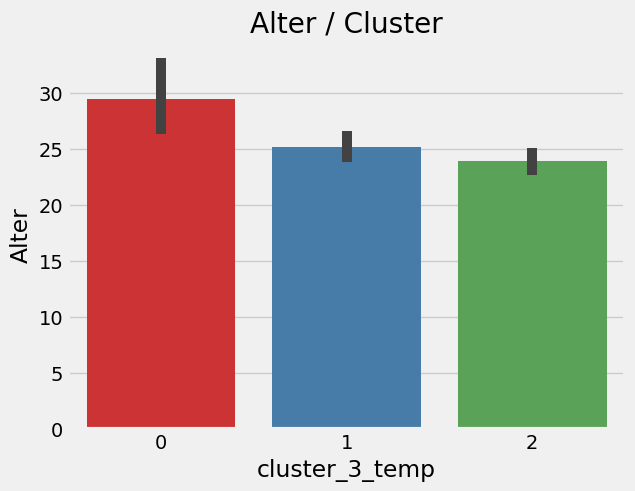

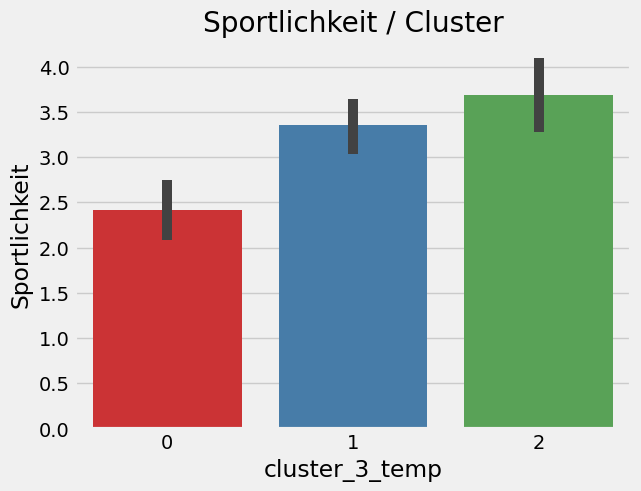

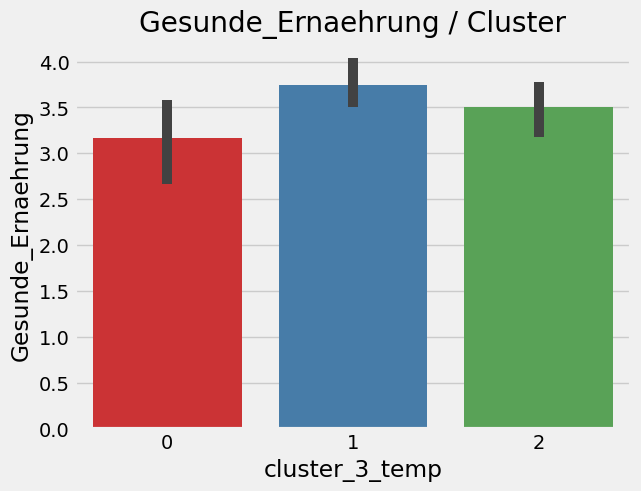

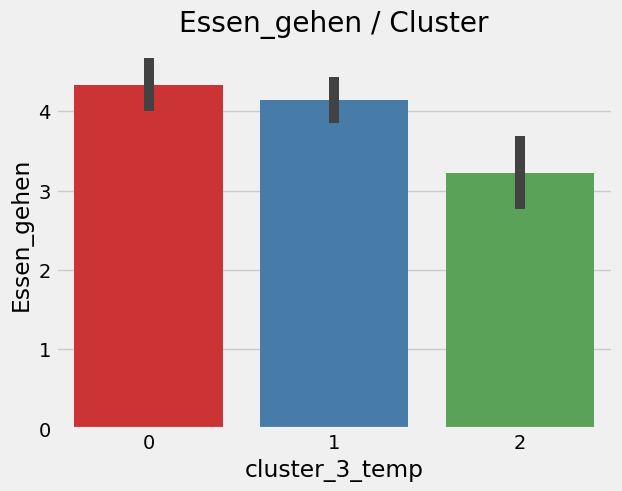

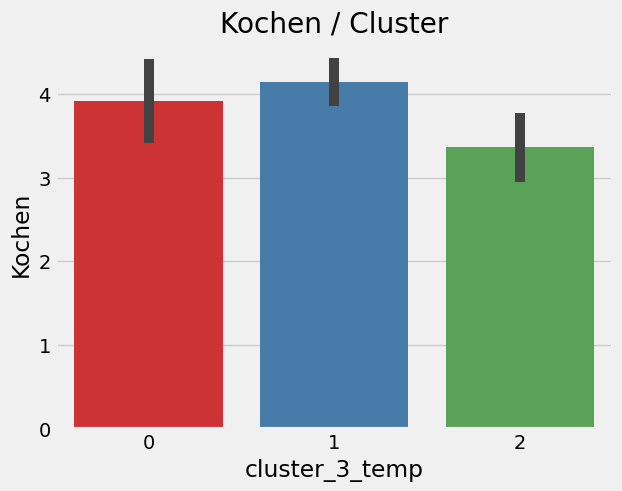

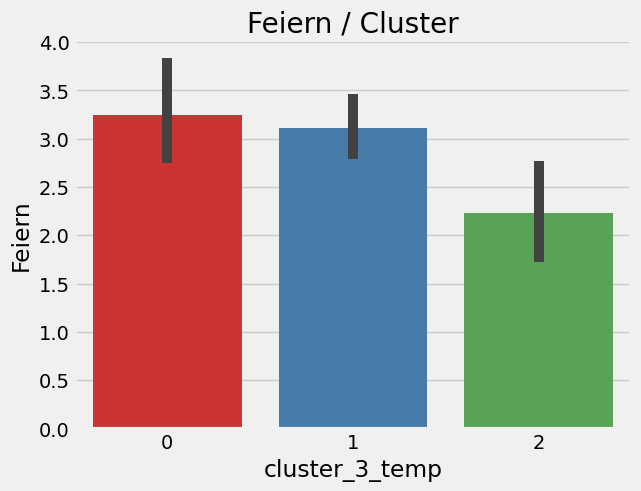

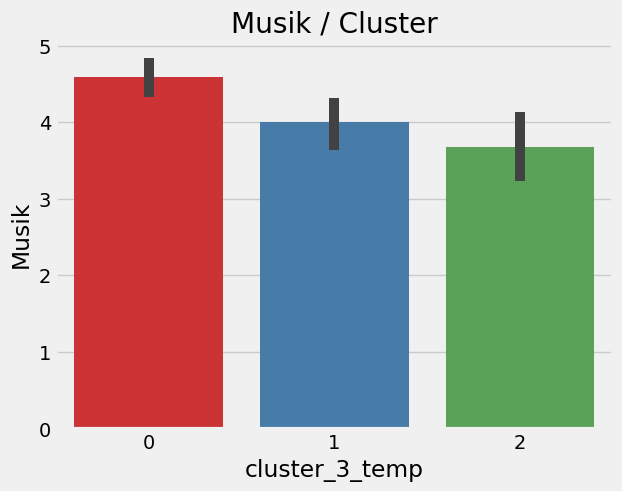

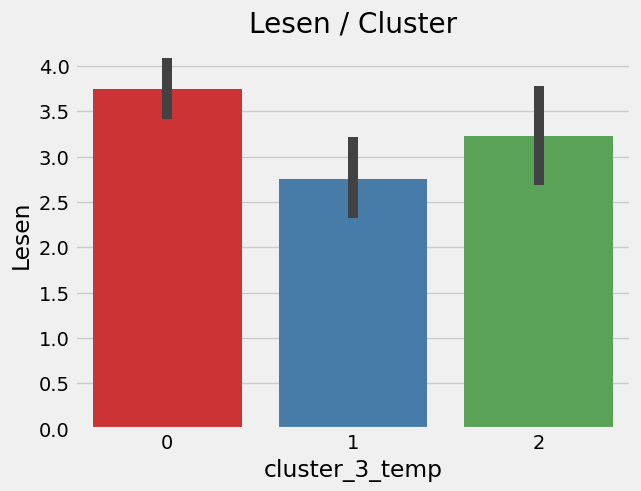

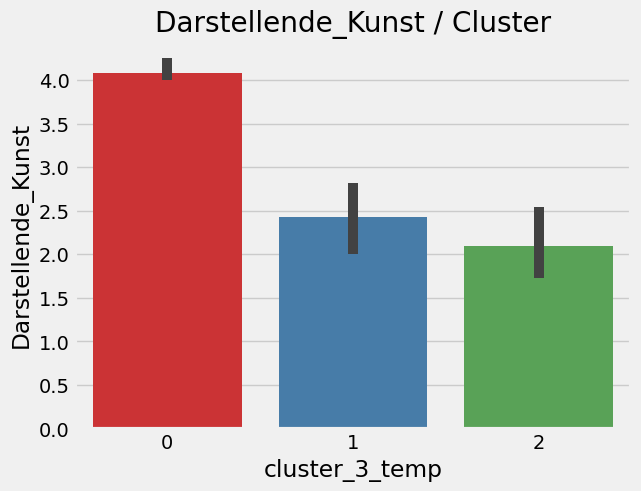

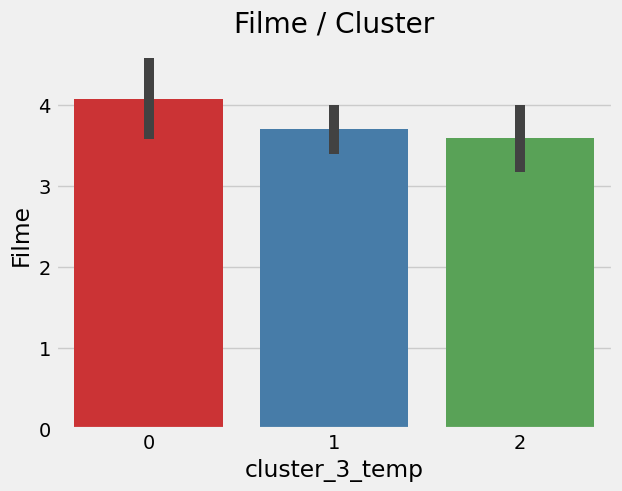

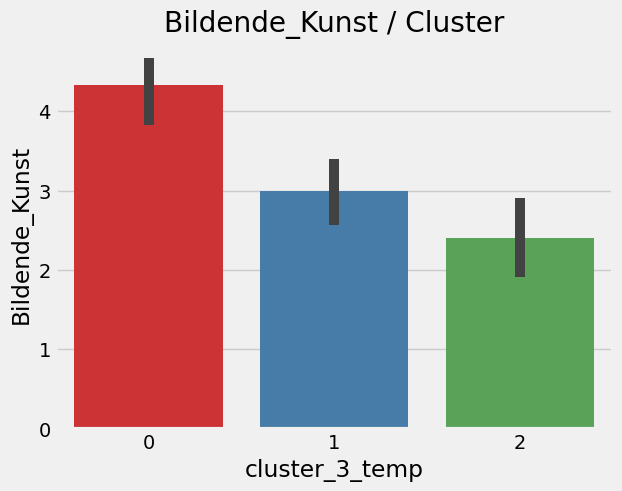

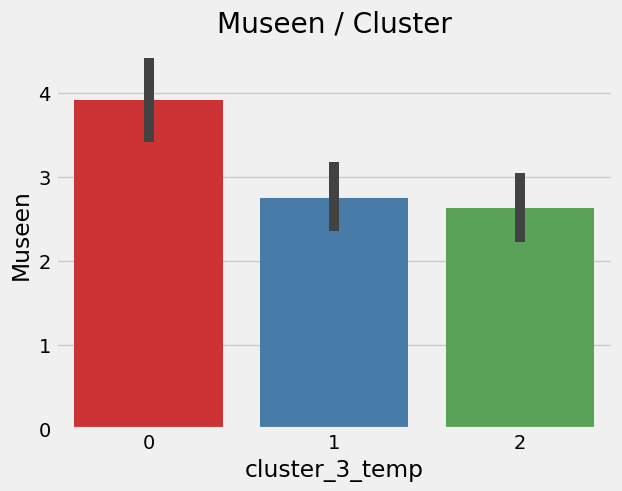

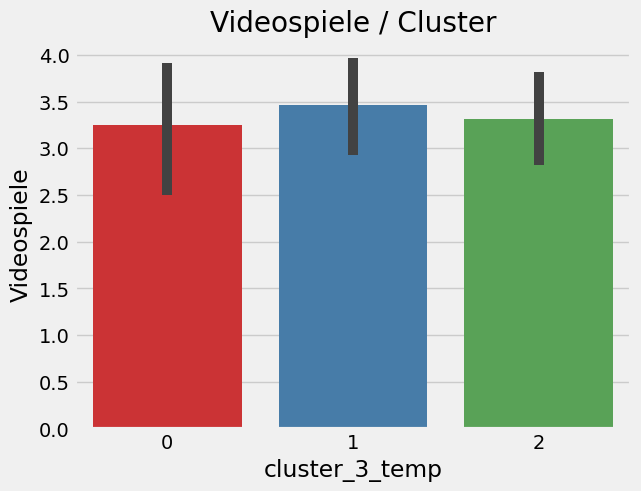

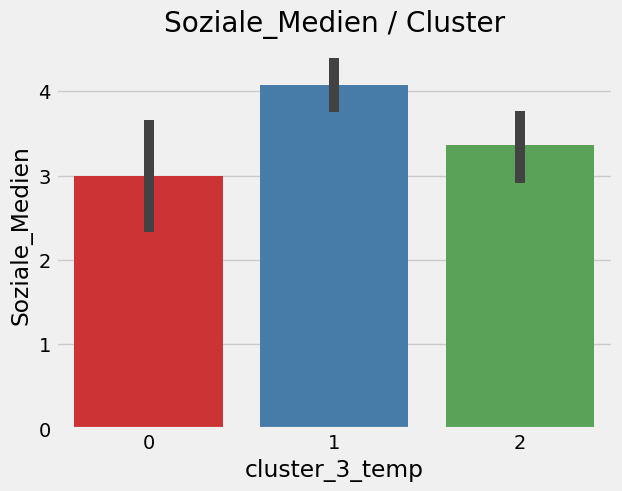

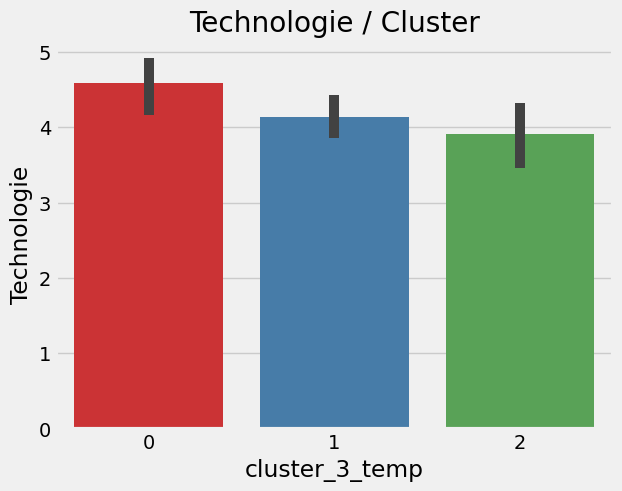

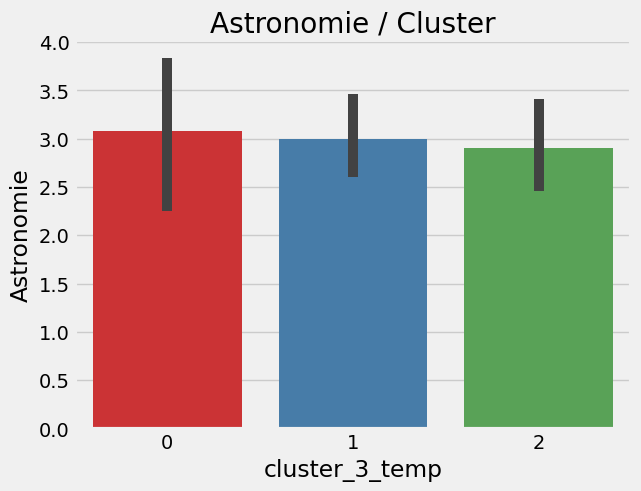

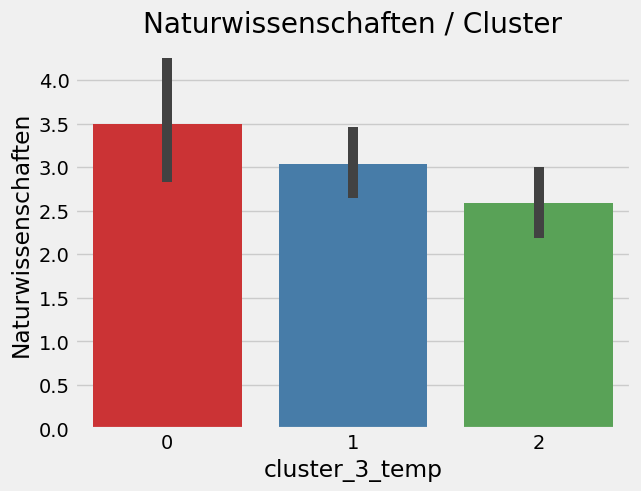

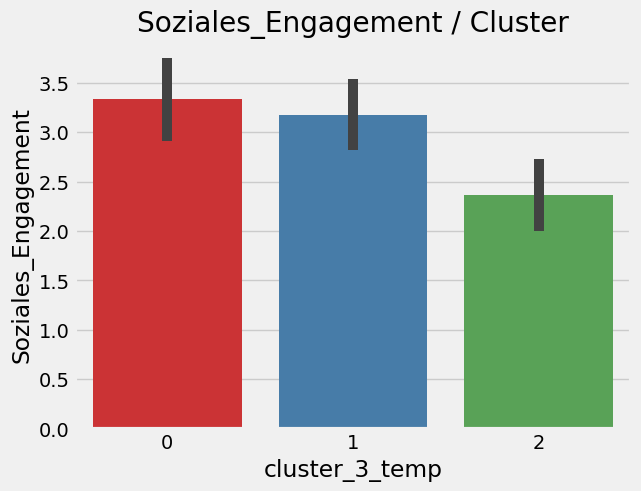

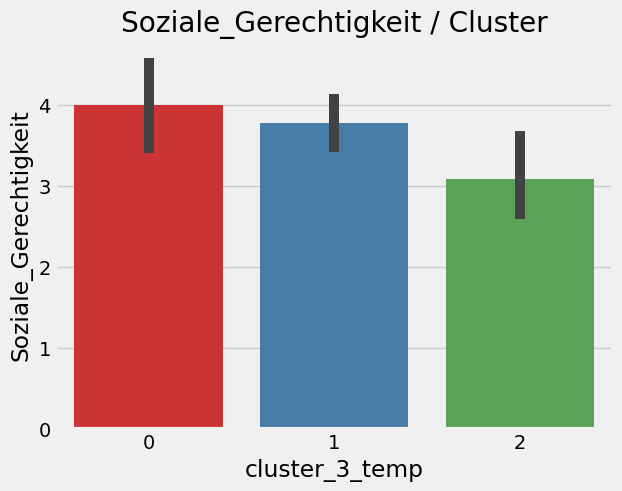

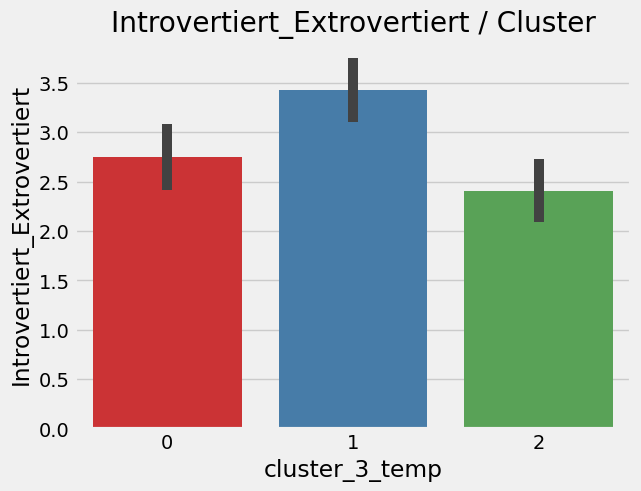

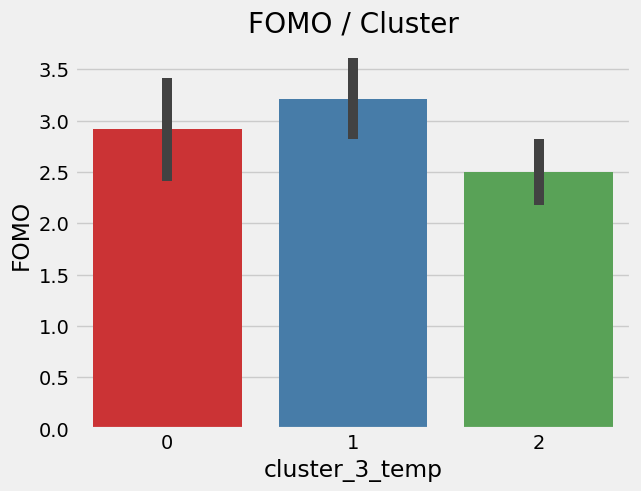

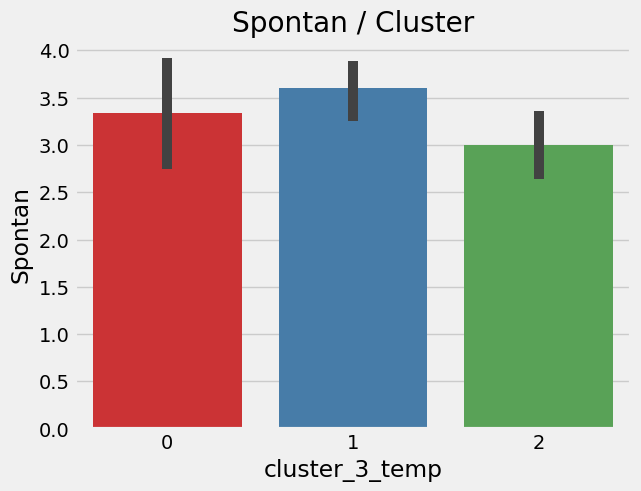

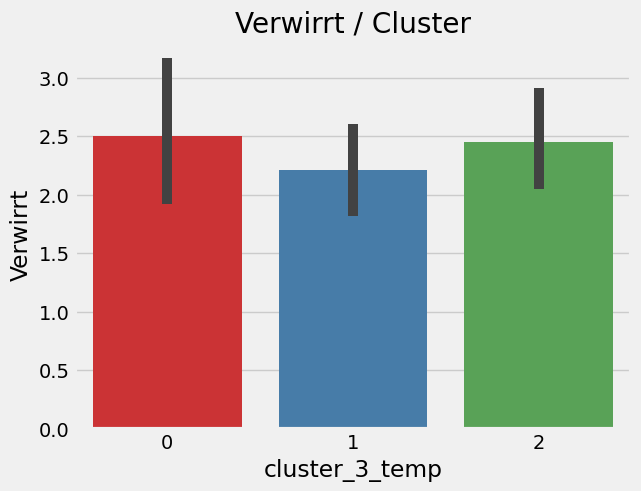

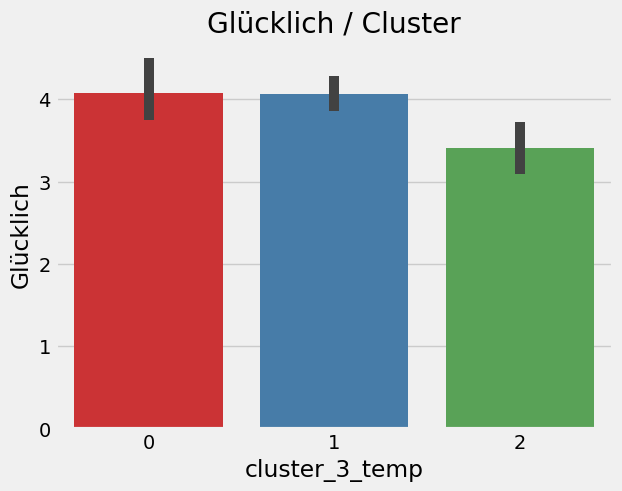

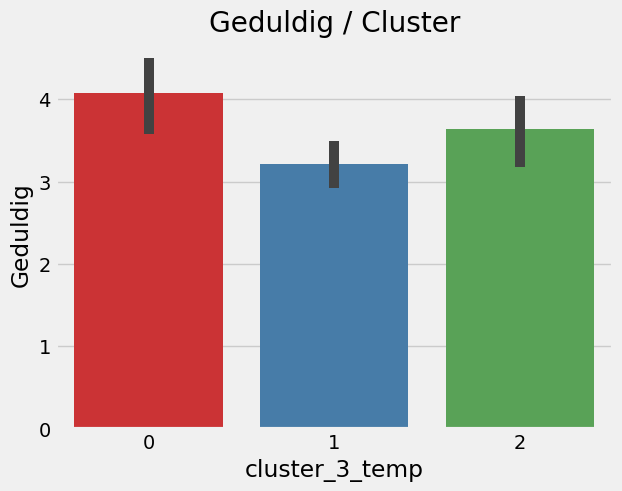

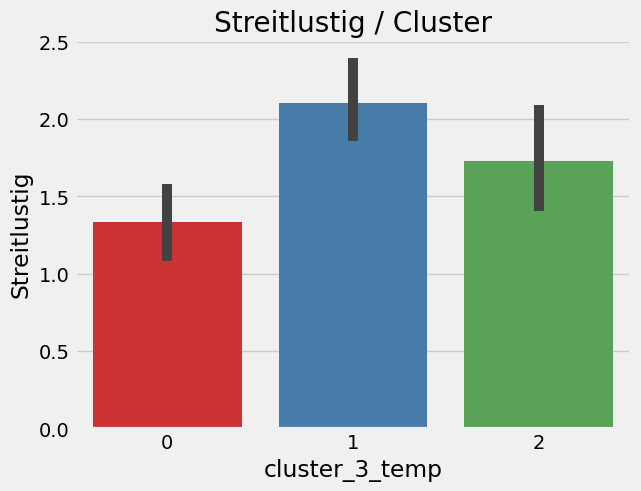

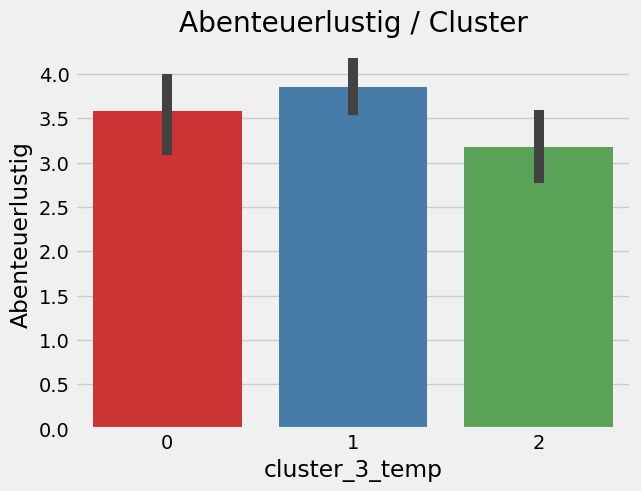

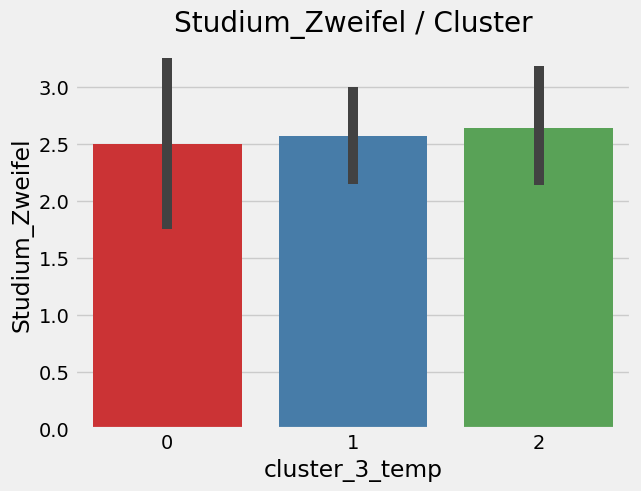

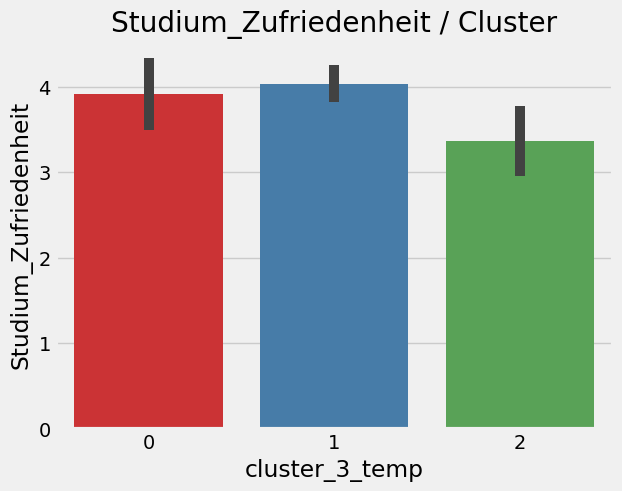

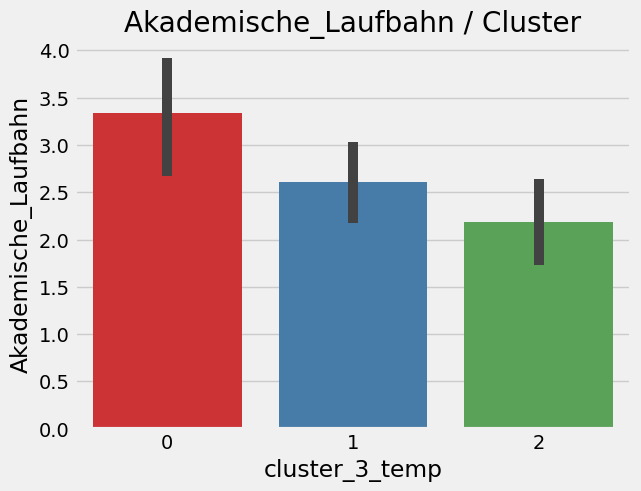

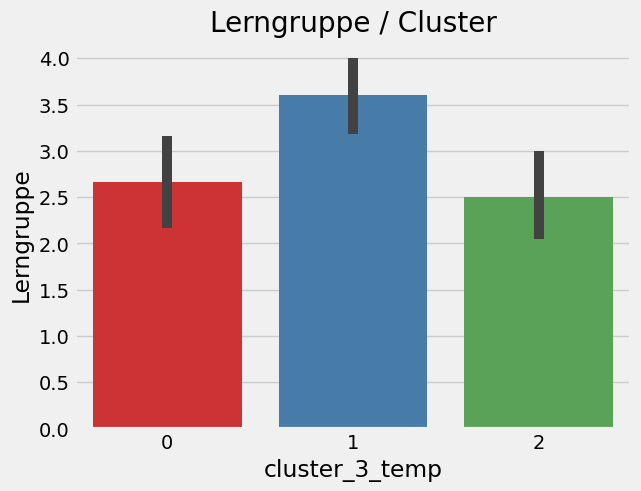

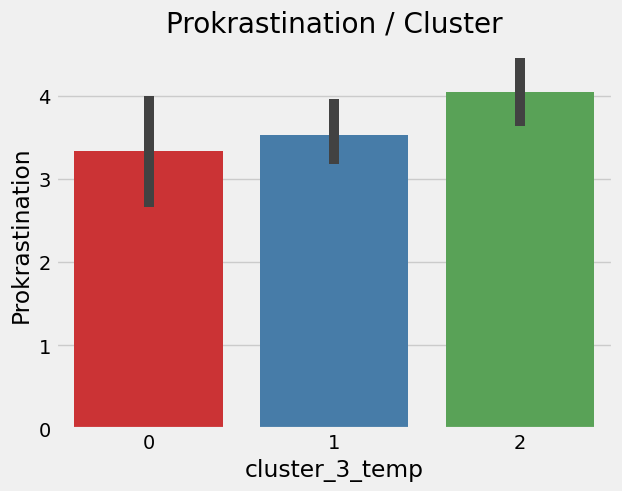

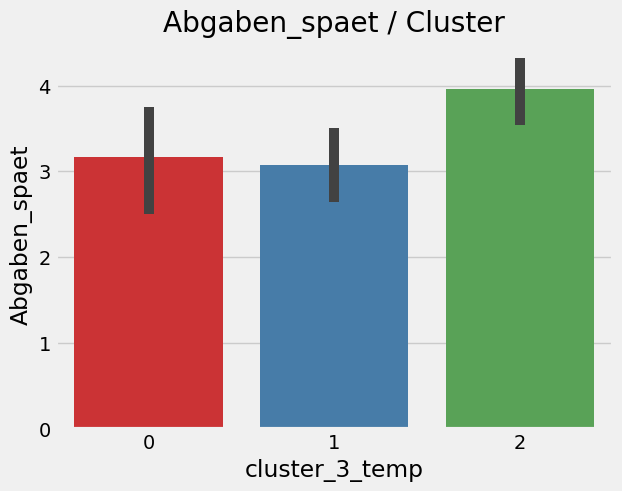

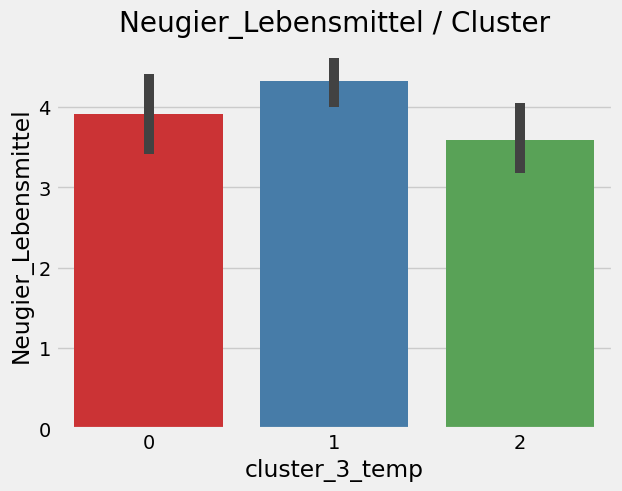

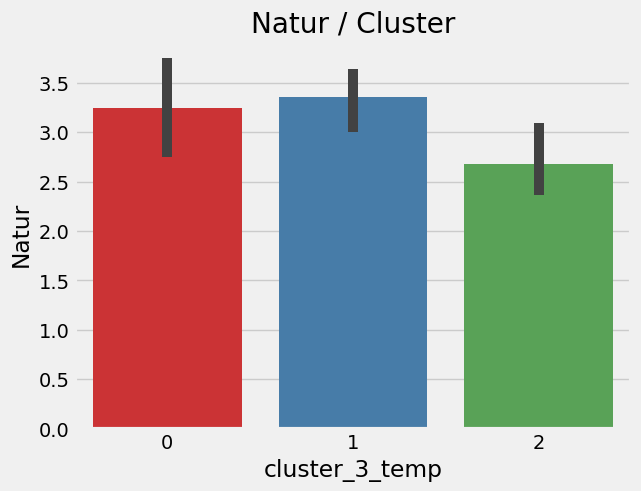

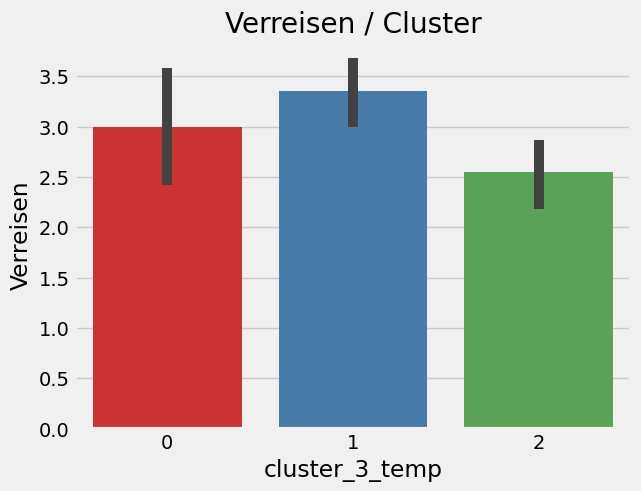

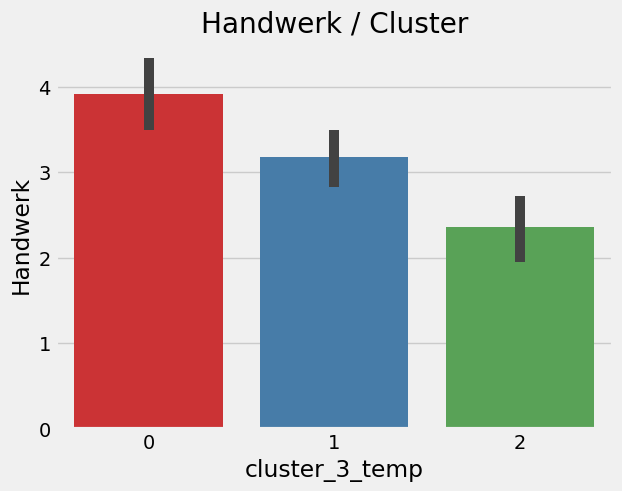

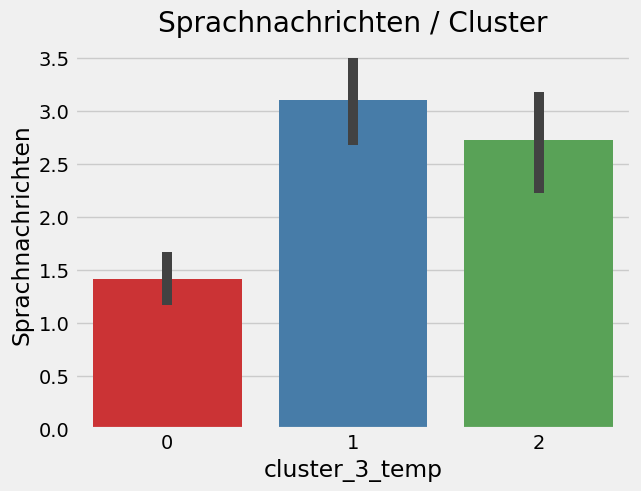

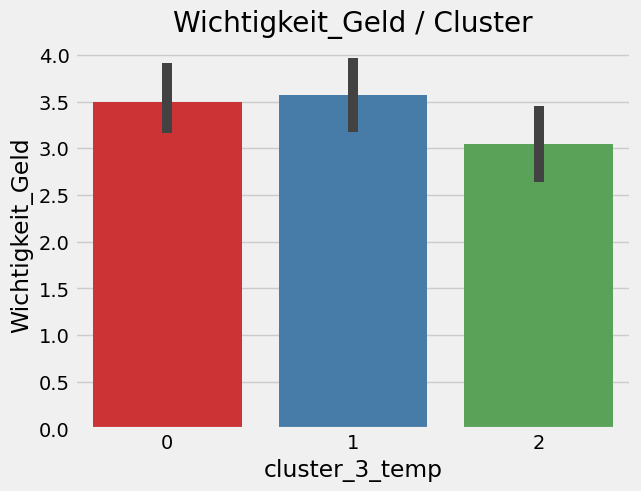

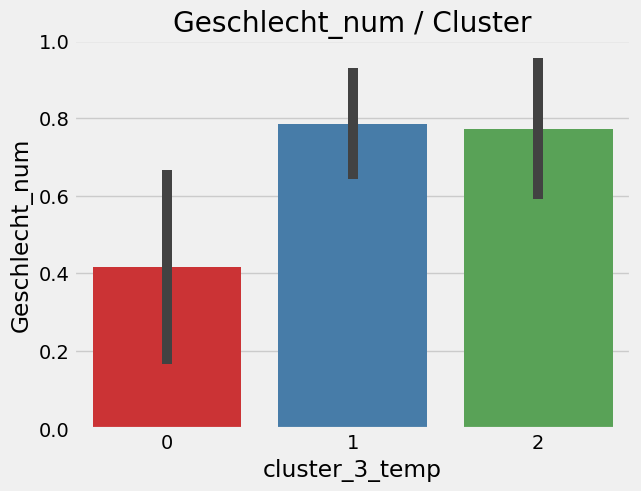

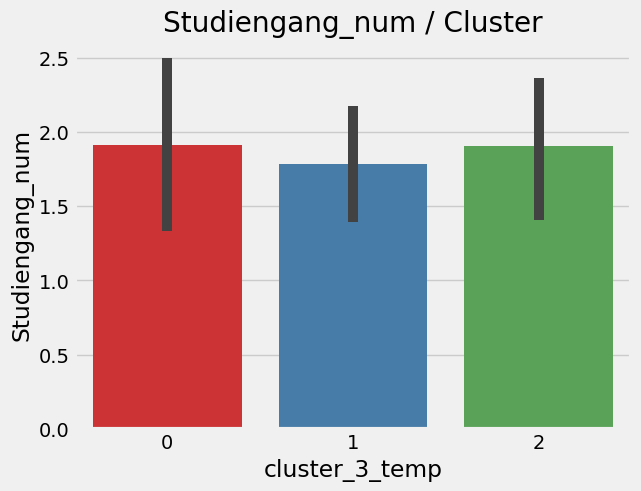

In [25]:
# Darstellen der Cluster-Verteilung
check_clustering(category_list=[data_num_wsf], clusters=3, show_cluster_bars=True)

Axes(0.08,0.07;0.87x0.81)


Index(['Natur', 'Museen', 'Abgaben_spaet', 'Prokrastination', 'Videospiele',
       'Soziale_Gerechtigkeit', 'Filme', 'Musik', 'Streitlustig',
       'Wichtigkeit_Geld', 'Studiengang_num', 'Gesunde_Ernaehrung', 'Verwirrt',
       'Astronomie', 'FOMO', 'Technologie', 'Studium_Zweifel',
       'Geschlecht_num'],
      dtype='object')

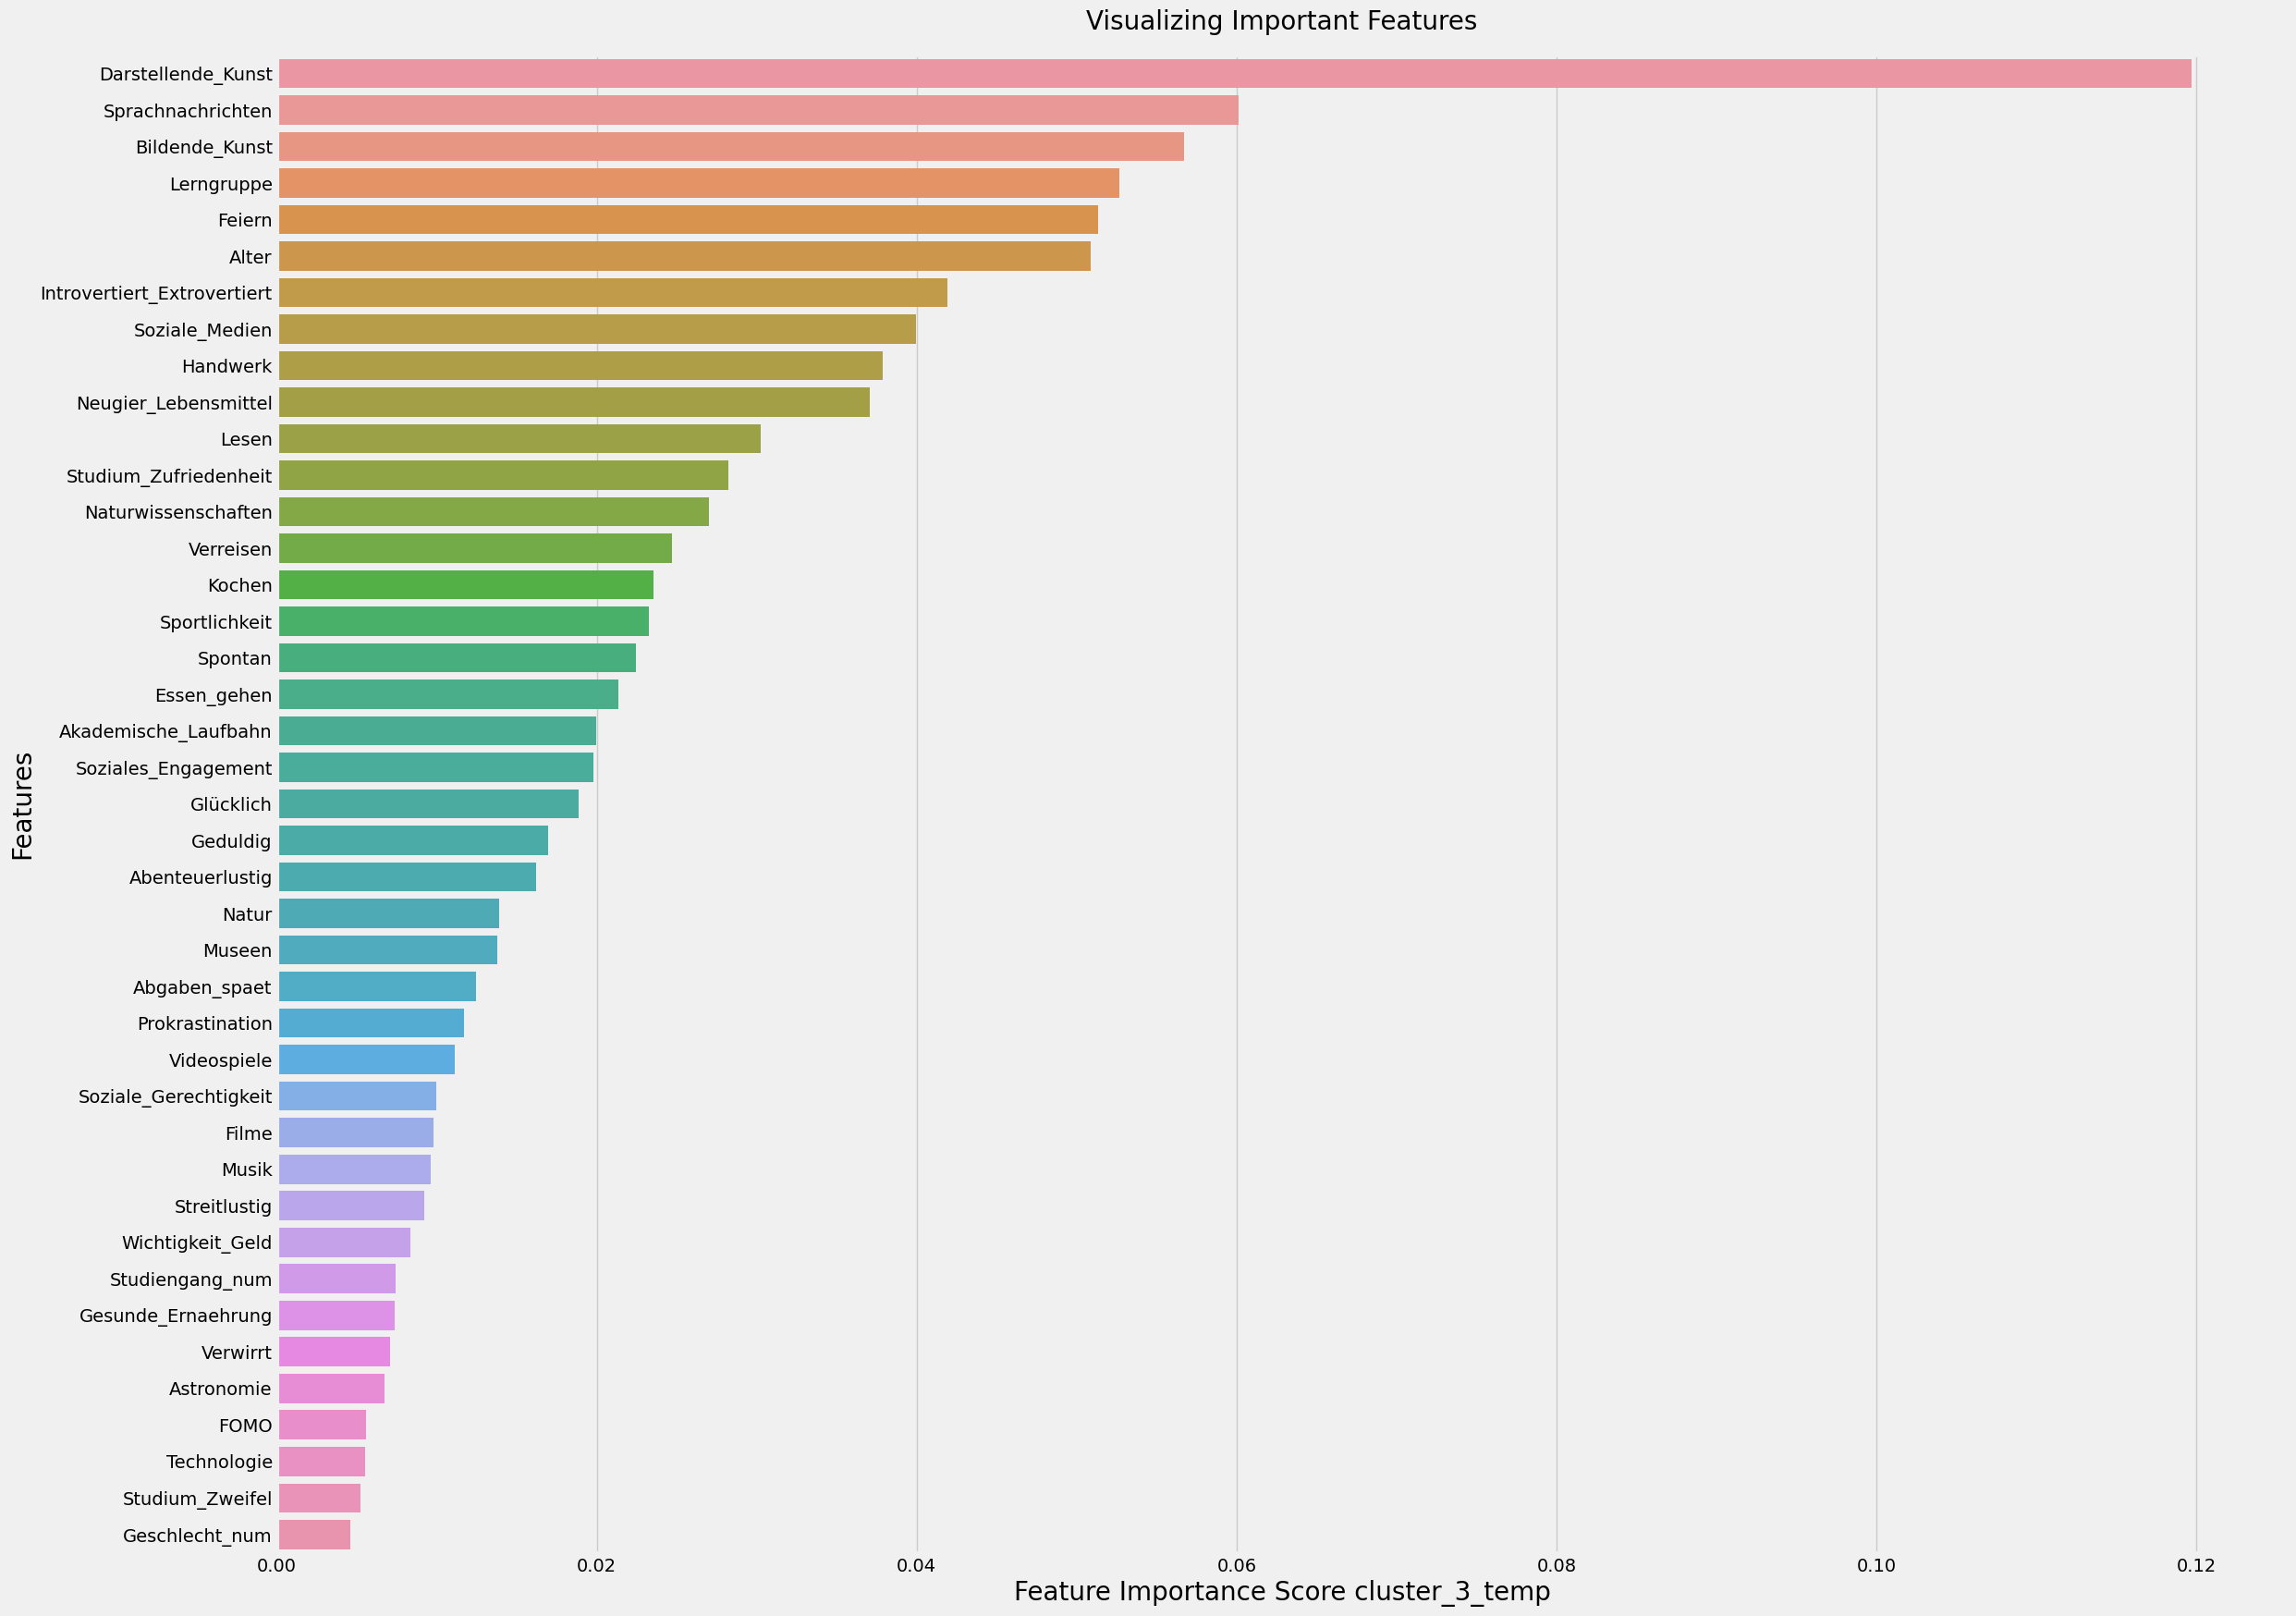

In [26]:
# Welche Features haben den meisten Einfluss auf die Cluster-Bildung?

data_wsf_clustered_3, cluster_name_wsf_3 = scaling_and_clustering(data_num_wsf, clusters=3)
columns_to_drop_wsf_3= feature_selection(data=data_wsf_clustered_3, label_column=cluster_name_wsf_3, threshold=0.015)
columns_to_drop_wsf_3

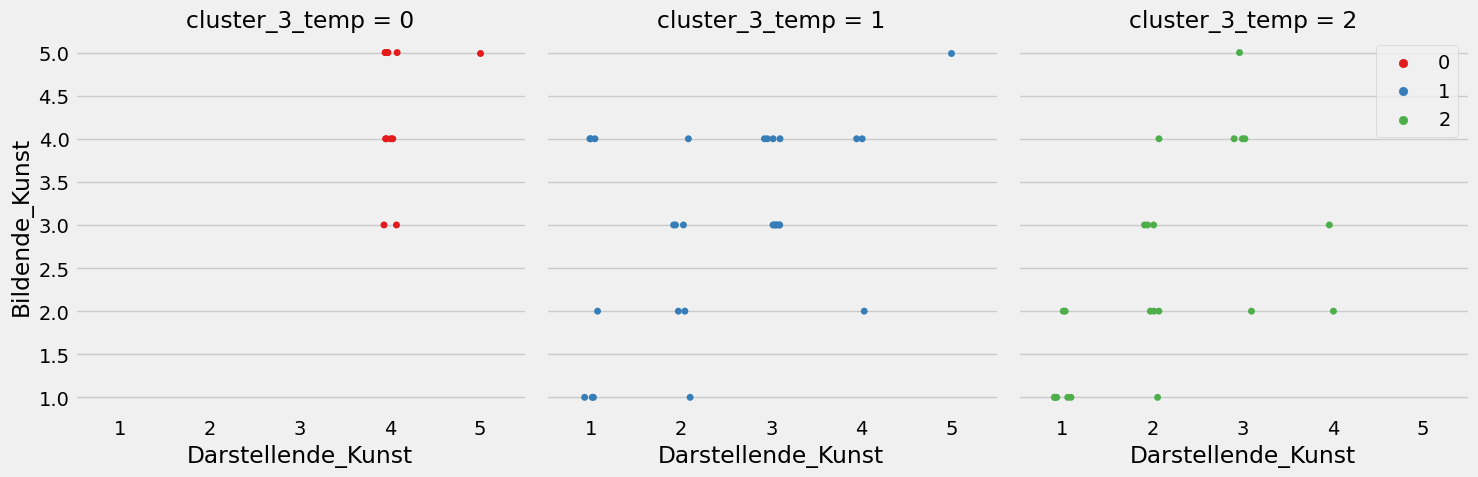

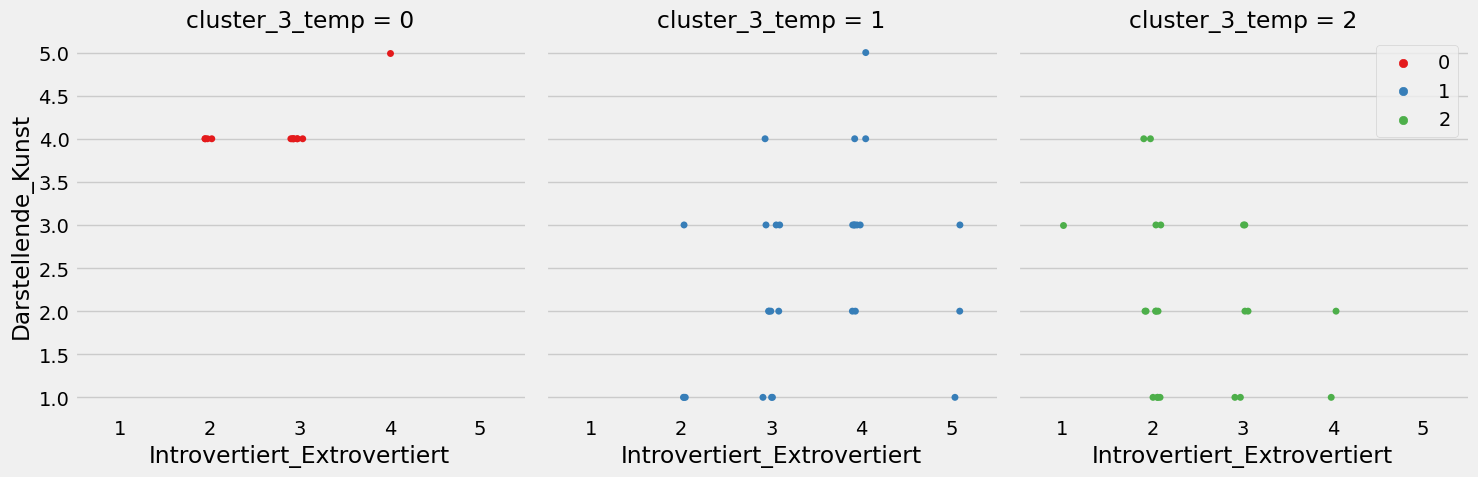

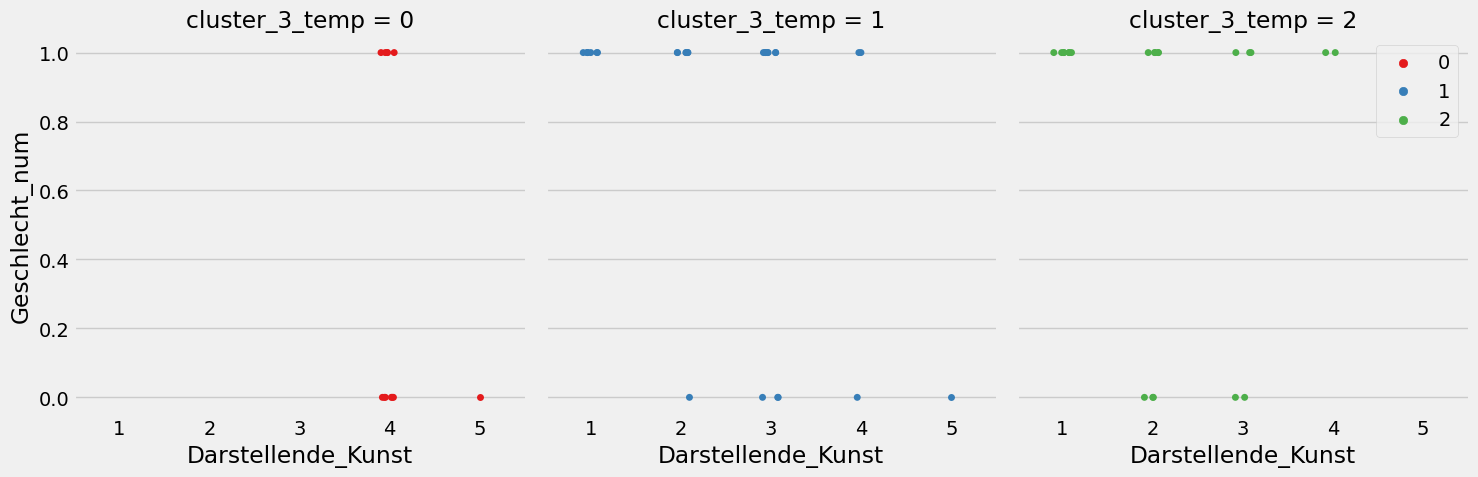

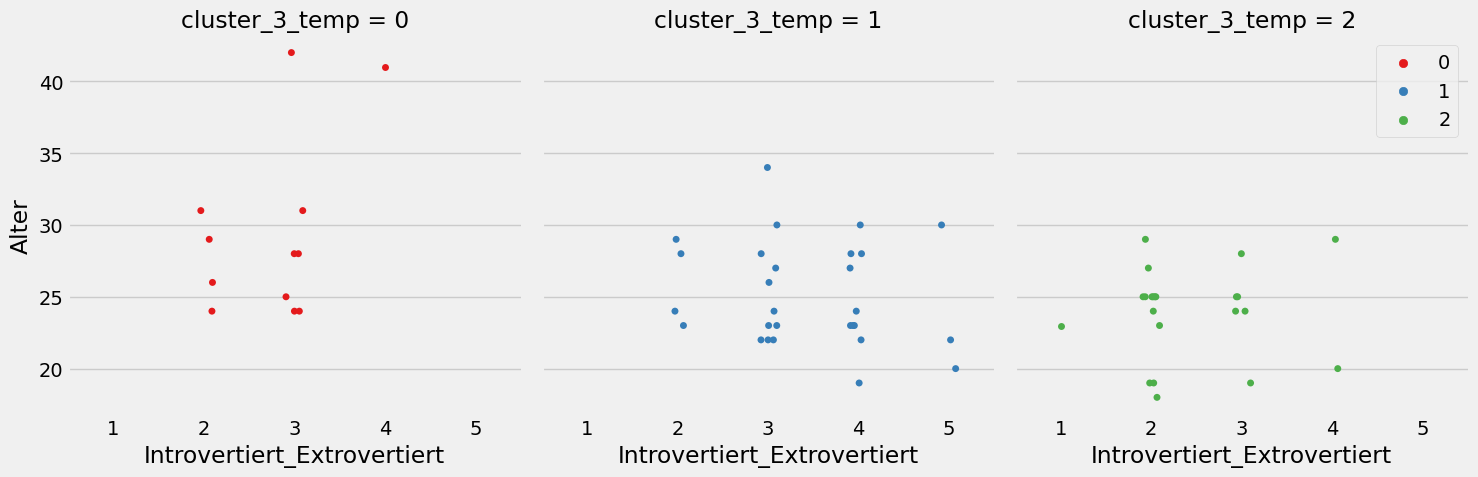

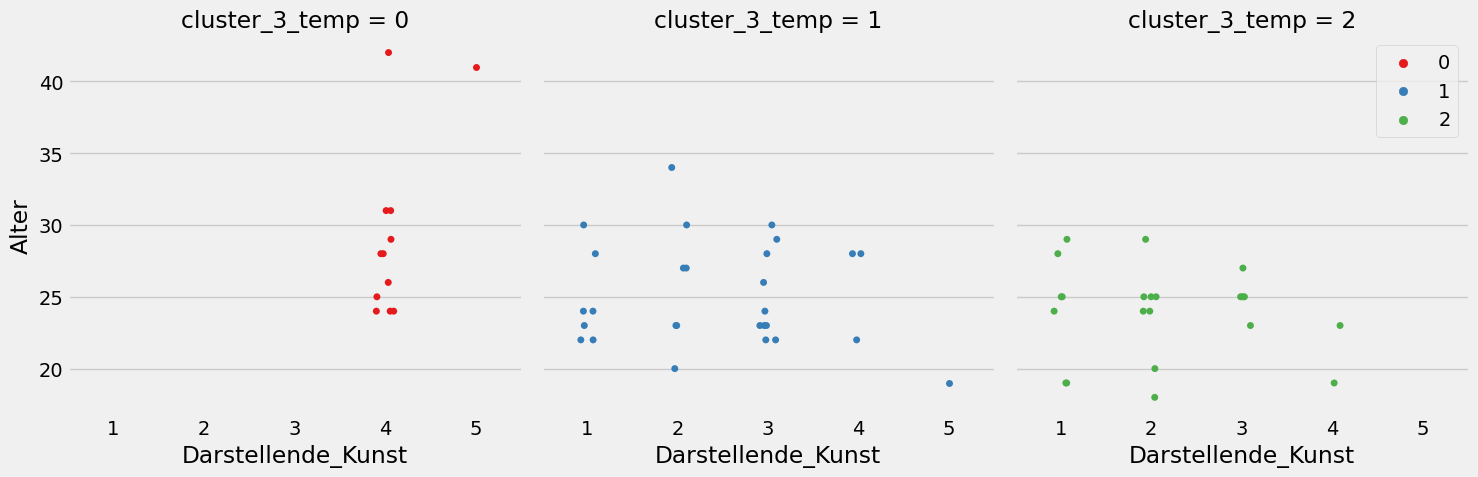

In [71]:
# Testweise Zeichnen weiterer Features als catplots, damit sie besser erkennbar sind

draw_catplot(data_wsf_clustered_3, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Introvertiert_Extrovertiert', 'Darstellende_Kunst', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Darstellende_Kunst', 'Geschlecht_num', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Introvertiert_Extrovertiert', 'Alter', cluster_name_wsf_3)
draw_catplot(data_wsf_clustered_3, 'Darstellende_Kunst', 'Alter', cluster_name_wsf_3)

## 2 Cluster

Am besten wurden 2.3 oder 5 Cluster bewertet. Test von 2 Clustern.

ERGEBNIS: Aufteilung in 2 Cluster wurde verworfen, weil man bei drei Clustern mehr erkennen kann.

Daten von hier ab: In den für die Cluster verwendeten Daten sind die Sportarten nicht einzeln dabei, sondern ein sports_factor. Außerdem wurde Position_num entfernt, weil bis auf drei Teilnehmer alle dieselben Angaben haben und der Datensatz daher sehr biased.

Unterscheidungen der Cluster:
- Rot ist älter und breiter gestreut
- Rot ist weniger sportlich (< 3.0), Blau sportlicher (> 3.5)
- gesunde Ernährung gleich
- Rot geht lieber essen (> 4.0, weniger Streuung), Blau ca. 3.3
- Rot kocht lieber (4.0), Blau ca. 3.5
- Rot feiert lieber (ca. 3.3), Blau < 2.5
- Rot mag Musik, Lesen und Filme lieber
- Rot mag Darstellende, Bildende Kunst und Museen sehr viel lieber (>3.0, >3.5, >3.0), Blau < 2.0, < 2.5, <2.5
- Blau spielt lieber Videospiele (aber größere Streuung und wenig Unterschied)
- Rot benutzt lieber Soziale Medien (aber größere Streuung und wenig Unterschied)
- Rot mag Technologie lieber (aber wenig Unterschied)
- Astronomie fast gleich
- Rot mag Naturwissenschaften lieber (Aber größere Streuung)
- Rot hat höheres Interesse an Sozialem Engagement und Sozialer Gerechtigkeit
- Rot ist Extrovertierter (ca. 3.3) als Blau (ca. 2.6)
- Rot hat mehr FOMO
- Rot ist spontaner, glücklicher und abenteuerlustiger (wenig Unterschied)
- verwirrt sind beide gleich
- blau ist geduldiger und streitlustiger (höhere Streuung, wenig Unterschied)
- Blau hat mehr Zweifel am Studium (höhere Streuung, wenig Unterschied)
- Rot ist zufriedener im Studium (wenig Unterschied)
- Rot strebt mehr eine Akademische Laufbahn an (3.0) als Blau (2.1)
- Rot lernt lieber in Lerngruppen (größere Streuung)
- Blau prokrastiniert eher (größere Streuung, wenig Unterschied)
- Blau gibt Aufgaben eher spät ab (größere Streuung, wenig Unterschied)
- Rot hat mehr Interesse an neuen Lebensmitteln (wenig Unterschied)
- Rot ist lieber in der Natur
- Rot verreist lieber (größere Streuung, wenig Unterschied)
- Rot mag Handwerk lieber (3.5) als Blau (2.5)
- Sprachnachrichten sind beide gleich, breite Streuung)
- Geld ist Rot wichtiger als Blau (wenig Unterschied)
- Rot beinhaltet mehr Frauen (0.6, breite Streuung) als Blau (> 0.8)



In [28]:
# Darstellen der Cluster-Verteilung
# Einkommentieren und ausführen für Darstellung

# check_clustering(category_list=[data_num_wsf], clusters=2, show_cluster_bars=True)

In [29]:
# Welche Features haben den meisten Einfluss auf die Cluster-Bildung?
# Einkommentieren und ausführen für Darstellung
#(Berechnung nicht auskommentiert, da die für die Dateierstellung benötigt wird)

data_wsf_clustered_2, cluster_name_wsf_2 = scaling_and_clustering(data_num_wsf, clusters=2)
#columns_to_drop_wsf_2= feature_selection(data=data_wsf_clustered_2, label_column=cluster_name_wsf_2, threshold=0.015)
#columns_to_drop_wsf_2

In [30]:
# Zeichnen der beiden Features, die den größten Einfluss hatten
# Einkommentieren und ausführen für Darstellung

#draw_stripplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_2)

In [31]:
# Testweise Zeichnen weiterer Features als catplots, damit sie besser erkennbar sind
# Einkommentieren und ausführen für Darstellung

#draw_catplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_2)
#draw_catplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Introvertiert_Extrovertiert', cluster_name_wsf_2)
#draw_catplot(data_wsf_clustered_2, 'Introvertiert_Extrovertiert', 'Geschlecht_num', cluster_name_wsf_2)
#draw_catplot(data_wsf_clustered_2, 'Introvertiert_Extrovertiert', 'sports_factor', cluster_name_wsf_2)
#draw_catplot(data_wsf_clustered_2, 'Introvertiert_Extrovertiert', 'Alter', cluster_name_wsf_2)
#draw_catplot(data_wsf_clustered_2, 'Darstellende_Kunst', 'Alter', cluster_name_wsf_2)

## 5 Cluster

ERGEBNIS: Aufteilung in 5 Cluster wurde verworfen, weil man bei drei Clustern mehr erkennen kann.

- Blau ist am ältesten, Grün am jüngsten
- Grün ist am sportlichsten, Rot am wenigsten sportlich
- gesunde Ernährung ist basically gleich
- Blau geht am liebsten essen, Lila am wenigsten
- Rot kocht am liebsten, Lila am wenigsten
- Blau geht am liebsten feiern, Lila und Rot am wenigsten
- Rot mag Musik am meisten, Grün am wenigsten
- Rot liest am liebsten, Grün am wenigsten (breite Streuung)
- Rot mag am liebsten Darstellende Kunst, Orange am zweitwenigsten, Grün am wenigsten
- Alle gucken gerne Filme außer Grün (Rot hat die höchste Streuung)
- Rot mag Bildende Kunst am liebsten, Grün am wenigsten
- Rot mag Museen am liebsten (breite Streuung), Grün am wenigsten
- Blau spielt am liebsten Videospiele, Orange und Rot am wenigsten
- Blau mag am liebsten soziale Medien, Rot am wenigsten (aber sehr breite Streuung)
- Rot mag Technologie am meisten, Orange am wenigsten
- Blau und Grün interessieren sich am meisten für Astronomie, Rot und Orange am wenigsten
- Blau interessiert sich am meisten für Naturwissenschaften, Rot und Orange am wenigsten
- Rot hat am meisten Interese an Sozialem Engagement, Lila am wenigsten
- Blau hat am meisten Interesse an sozialer Gerechtigkeit, Rot am wenigsten
- Blau und Orange sind am extrovertiertesten (nahe 3), Rot und Lila am introvertiertesten (um die 2.5)
- Blau hat am meisten FOMO, Rot und Grün am wenigsten
-  bis auf Lila sind alle relativ gleich spontan Lila weniger
-  Lila ist am verwirrtesten, Rot am wenigsten verwirrt
- Rot ist am glücklichsten, Lila am wenigsten glücklich
- Rot ist am geduldigsten, Grün am wenigsten geduldig
- Orange ist am streitlustigsten, Rot am wenigsten
- Alle sind abenteuerlustig bis auf Lila
- Lila hat die meisten Studienzweifel, Rot die wenigsten
- Rot ist am zufriedensten im Studium, Lila und Orange am wenigsten
- Blau will am ehesten eine akademische Laufbahn verfolgen, Rot, Grün und ORange am wenigsten (aber sehr breite Streuung)
- Orange und Blau lernen am liebsten in LErngruppen, Rot und Lila am wenigsten
- Lila prokrastiniert am meisten und gibt Abgaben am spätesten ab, Rot am wenigsten
- Rot und Lila sind weniger neugierig auf Lebensmittel als die anderen
- Orange ist am liebsten in der Natur, Lila am wenigsten
- Orange verreist am liebsten, Lila am wenigsten
- Rot interessiert sich am meistne fr Handwerk (breite Streuung), Grün am wenigsten
- Rot mag am wenigsten Sprachnachrichten
- Blau ist Geld am wichtigsten, Orange, ila und Rot am wenigsten wichtig
- Rot ist gleichmäßig aufgeteilt zw. Männern und Frauen, Grün hat den größten Männeranteil, hier sind alle außer Rot über 0.6

In [32]:
# Darstellen der Cluster-Verteilung
# Einkommentieren und ausführen für Darstellung

#check_clustering(category_list=[data_num_wsf], clusters=5, show_cluster_bars=True)

In [33]:
# Einkommentieren und ausführen für Darstellung
#(Berechnung nicht auskommentiert, da die für die Dateierstellung benötigt wird)

data_wsf_clustered_5, cluster_name_wsf_5 = scaling_and_clustering(data_num_wsf, clusters=5)
#columns_to_drop_wsf_5= feature_selection(data=data_wsf_clustered_5, label_column=cluster_name_wsf_5, threshold=0.015)
#columns_to_drop_wsf_5

In [34]:
# Einkommentieren und ausführen für Darstellung

#draw_catplot(data_wsf_clustered_5, 'Darstellende_Kunst', 'Bildende_Kunst', cluster_name_wsf_5)
#draw_catplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Handwerk', cluster_name_wsf_5)
#draw_catplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Darstellende_Kunst', cluster_name_wsf_5)
#draw_catplot(data_wsf_clustered_5, 'Darstellende_Kunst', 'Alter', cluster_name_wsf_5)
#draw_catplot(data_wsf_clustered_5, 'Naturwissenschaften', 'Alter', cluster_name_wsf_5)

## Analyse Kategorien

HINWEIS: Das Clustering der einzelnen Kategorien war zwar nicht uninteressant, aber für die Endaufgabe nicht relevant/ hat nichts beigetragen. Daher sind alle Testschritte im Weiteren auskommentiert (es sind dieselben wie für die vorhergehende Cluster-Analyse, nur für die Kategorien einzeln) und können bei Bedarf einkommentiert werden.

- elbow und silhouette coefficients berechnen
- Kategorien mit PCA und tSNE anschauen (in den clusterstärken, die von den coefficients suggested werden)
- cluster und feature importance berechnen

In [35]:
#sports
sports_columns = columns_sports.copy()
sports_columns.extend(columns_age)
sports_columns.extend(columns_sex_num)
sports_columns.extend(columns_studiengang_num)
data_sports = data_num.copy()[sports_columns]

scaler_sports = StandardScaler()
scaler_sports.fit(data_sports)
data_sports_scaled = pd.DataFrame(scaler_sports.transform(data_sports),
                           columns= data_sports.columns )


#lifestyle
lifestyle_columns = columns_lifestyle.copy()
lifestyle_columns.extend(columns_age)
lifestyle_columns.extend(columns_sex_num)
lifestyle_columns.extend(columns_studiengang_num)

data_lifestyle = data_num.copy()[lifestyle_columns]
data_lifestyle_scaled= data_num_wsf_scaled.copy()[lifestyle_columns]

#kultur
kultur_columns = columns_kultur.copy()
kultur_columns.extend(columns_age)
kultur_columns.extend(columns_sex_num)
kultur_columns.extend(columns_studiengang_num)

data_kultur = data_num.copy()[kultur_columns]
data_kultur_scaled= data_num_wsf_scaled.copy()[kultur_columns]

#tech
tech_columns = columns_tech_sci.copy()
tech_columns.extend(columns_age)
tech_columns.extend(columns_sex_num)
tech_columns.extend(columns_studiengang_num)

data_tech = data_num.copy()[tech_columns]
data_tech_scaled = data_num_wsf_scaled.copy()[tech_columns]

#sozial
social_columns = columns_social.copy()
social_columns.extend(columns_personality)
social_columns.extend(columns_age)
social_columns.extend(columns_sex_num)
social_columns.extend(columns_studiengang_num)

data_social = data_num.copy()[social_columns]
data_social_scaled = data_num_wsf_scaled.copy()[social_columns]

#studium
studium_columns = columns_studium.copy()
studium_columns.extend(columns_age)
studium_columns.extend(columns_sex_num)
studium_columns.extend(columns_studiengang_num)

data_studium = data_num.copy()[studium_columns]
data_studium_scaled = data_num_wsf_scaled.copy()[studium_columns]

In [36]:
#elbow_and_silhouette(data_sports_scaled, "sports") #sse=2 oder 4; silhouette=5
#elbow_and_silhouette(data_lifestyle_scaled, "lifestyle") #sse=2 oder 4; silhouette=5, 7, 10
#elbow_and_silhouette(data_kultur_scaled, "culture") #sse=2 oder 4; silhouette=2,4,9,10
#elbow_and_silhouette(data_tech_scaled, "tech") #sse=2 oder 5; silhouette=2,5
#elbow_and_silhouette(data_social_scaled, "social") #sse=7 oder 9; silhouette=3,9
#elbow_and_silhouette(data_studium_scaled, "studium") #sse=2 oder 4; silhouette=5

In [37]:
#category_list_cluster_check = [data_sports, 
#                               data_lifestyle, 
#                               data_kultur, 
#                               data_tech, 
#                               data_social,
#                               data_studium]
#category_list_cluster_check_scaled = [data_sports_scaled, 
#                               data_lifestyle_scaled, 
#                               data_kultur_scaled, 
#                               data_tech_scaled, 
#                               data_social_scaled,
#                               data_studium_scaled]
#Notizen
#elbow_and_silhouette(data_sports_scaled, "sports") #sse=2 oder 8; silhouette=2,8
#elbow_and_silhouette(data_lifestyle_scaled, "lifestyle") #sse=2 oder 4; silhouette=5, 7, 10
#elbow_and_silhouette(data_kultur_scaled, "culture") #sse=2 oder 4; silhouette=2,4,9,10
#elbow_and_silhouette(data_tech_scaled, "tech") #sse=2 oder 5; silhouette=2,5
#elbow_and_silhouette(data_social_scaled, "social") #sse=7 oder 9; silhouette=3,9
#elbow_and_silhouette(data_studium_scaled, "studium") #sse=2 oder 4; silhouette=5

In [38]:
#dimension_reduction(data_sports_scaled, 2, 50)

#dimension_reduction(data_lifestyle_scaled, 2, 50)

#dimension_reduction(data_kultur_scaled, 2, 50)

#dimension_reduction(data_tech_scaled, 2, 50)

#dimension_reduction(data_social_scaled, 3, 50)

#dimension_reduction(data_studium_scaled, 2, 50)

In [45]:
def generic_feature_selection(data, clusters):
    data_temp, cluster_name_temp = scaling_and_clustering(data, clusters=clusters)
    columns_to_drop_temp= feature_selection(data=data_temp, label_column=cluster_name_temp, threshold=0.015)
    columns_to_drop_temp

def category_feature_selection(category_list, clusters):
    for data in category_list:
        generic_feature_selection(data, clusters)

In [46]:
#category_feature_selection(category_list_cluster_check, 2)

# Hierarchical Clustering

Hierarchical Clustering Analysis (HCA), weil unser Datensatz sehr klein ist. (https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)

Umsetzung mit den skalierten Daten von oben.

Linkage-Möglichkeiten siehe:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [47]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

## Alle numerischen Spalten: Test

In [48]:
#This process calculates the principal components that capture the most variance in the data. 
#The fit_transform method transforms the data into the new principal component space.
dimension_count = len(data_num.columns)
pca = PCA(n_components=dimension_count)
pca.fit_transform(data_all_scaled)
pca.explained_variance_ratio_.cumsum()

array([0.09060265, 0.16297896, 0.22863065, 0.28865193, 0.34279534,
       0.3877369 , 0.42921973, 0.46816396, 0.50558592, 0.54079695,
       0.5734532 , 0.60461423, 0.63271351, 0.65804298, 0.68274494,
       0.70484452, 0.72626892, 0.74625629, 0.76455906, 0.78206345,
       0.7993494 , 0.81506628, 0.82948194, 0.84327648, 0.85657999,
       0.86958157, 0.88177221, 0.89292566, 0.90381321, 0.91378345,
       0.92252483, 0.93061468, 0.9380814 , 0.94458643, 0.95055313,
       0.95640922, 0.96165369, 0.96632212, 0.97059492, 0.9743872 ,
       0.97767339, 0.98080981, 0.98361483, 0.98626835, 0.98871458,
       0.99055025, 0.99227179, 0.99367326, 0.99499902, 0.99613362,
       0.9972153 , 0.99804681, 0.99861657, 0.99914711, 0.99952394,
       0.99974601, 0.99987842, 0.99998799, 1.        ])

This code is performing PCA on a dataset with numerical features (data_num) to analyze how much variance can be explained by different numbers of principal components. It's not actually reducing the dimensions of the data in this specific code snippet, but it's providing insights into how many principal components are needed to capture a desired amount of variance.

--> Example: We look for at least 90% of explained variance. That's 29 Features

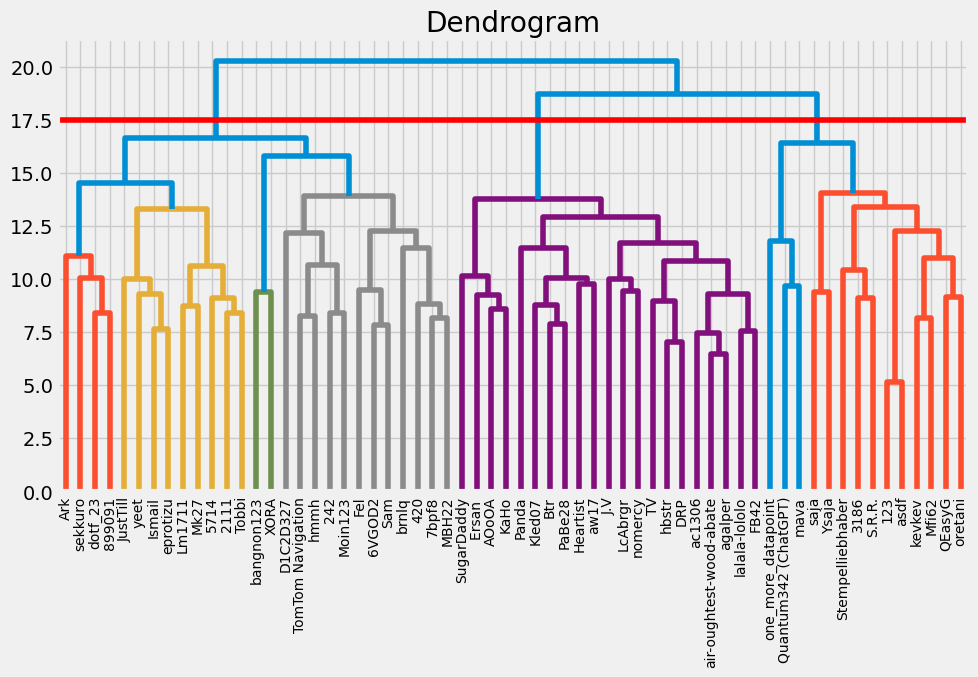

In [65]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")

# Einmal alle Daten aus den numerical columns verwenden
selected_data_all = data_all_scaled
clusters = shc.linkage(selected_data_all, 
            method='ward', 
            metric="euclidean")

# Extracting pseudonyms for labeling
labels = data["Pseudonym"].values

shc.dendrogram(Z=clusters, labels=labels, orientation='top')
plt.axhline(y = 17.5, color = 'r', linestyle = '-')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility
plt.tight_layout()       # Adjust layout to prevent label overlap
plt.show()

## Bearbeitete numerical columns (optional sports_factor)

Das sind die Daten, mit denen wir zuvor auch gearbeitet und die Cluster gebildet haben und mit denen wir in der Netzwerkanalyse weiterarbeiten.

In [67]:
dimension_count = len(data_num_wsf.columns)
pca = PCA(n_components=dimension_count)
pca.fit_transform(data_num_wsf_scaled)
pca.explained_variance_ratio_.cumsum()
#90% variance at 23 components

array([0.1136743 , 0.20562307, 0.28462683, 0.35895705, 0.41560127,
       0.46320489, 0.50798335, 0.55150881, 0.59327747, 0.63029128,
       0.663311  , 0.69300645, 0.72123224, 0.74558089, 0.76842369,
       0.79030953, 0.81068373, 0.82990565, 0.8479551 , 0.86501674,
       0.87984696, 0.89371369, 0.90713792, 0.91968917, 0.93125497,
       0.94094983, 0.94859682, 0.95557198, 0.96214757, 0.96808351,
       0.97383084, 0.97868889, 0.98267394, 0.98634619, 0.98939411,
       0.9920308 , 0.9943087 , 0.99640817, 0.99824965, 0.99958703,
       1.        ])

Beim Clustering ohne sports_factor entstehen Aufteilungen, in denen 3 oder 5 Cluster am besten funktionieren:

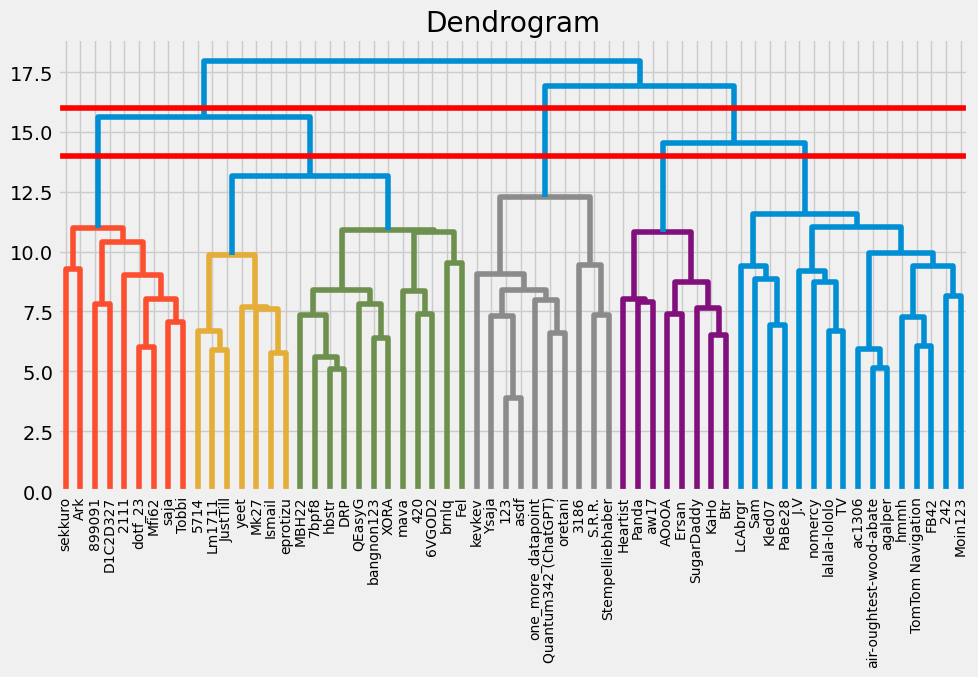

In [51]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")

# erst mal alle Daten aus den numerical columns verwenden
selected_data_wfs = data_num_wsf_scaled
clusters = shc.linkage(selected_data_wfs, 
            method='ward', 
            metric="euclidean")

# Extracting pseudonyms for labeling
labels = data["Pseudonym"].values

shc.dendrogram(Z=clusters, labels=labels, orientation='top')
plt.axhline(y = 16, color = 'r', linestyle = '-')
plt.axhline(y = 14, color = 'r', linestyle = '-')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility
plt.tight_layout()       # Adjust layout to prevent label overlap
plt.show()

# Speichern der Cluster in neue Datei zur Weiterverarbeitung

Für die Netzwerkanalyse. Dafür werden die Cluster von der KMeans-Anwendung verwendet.

In [53]:
data_cluster_save = data_num_wsf.copy()
data_cluster_save['cluster_2'] = data_wsf_clustered_2[cluster_name_wsf_2]
data_cluster_save

,Alter,Sportlichkeit,Gesunde_Ernaehrung,Essen_gehen,Kochen,Feiern,Musik,Lesen,Darstellende_Kunst,Filme,...,Abgaben_spaet,Neugier_Lebensmittel,Natur,Verreisen,Handwerk,Sprachnachrichten,Wichtigkeit_Geld,Geschlecht_num,Studiengang_num,cluster_2
0,28,4,4,3,4,3,5,4,3,3,...,2,5,5,2,2,3,3,1,3,1
1,26,3,4,4,5,2,4,2,3,4,...,2,4,3,3,4,3,4,1,3,1
2,24,2,5,4,4,3,5,2,3,4,...,1,3,2,3,2,4,3,1,3,1
3,23,5,2,4,4,2,3,3,2,4,...,3,5,4,4,2,3,3,1,3,0
4,24,3,4,3,2,1,3,4,2,5,...,5,2,3,4,3,3,4,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,26,1,4,4,5,2,5,3,4,5,...,1,4,3,2,3,1,3,1,3,1
58,22,3,3,4,4,3,4,1,1,2,...,3,4,3,4,4,1,5,1,2,0
59,25,3,3,4,3,2,4,4,3,3,...,4,4,5,3,4,2,2,0,2,1
60,31,3,4,5,5,3,5,4,4,5,...,2,5,4,4,3,2,3,0,0,1


In [54]:
data_cluster_save['cluster_3'] = data_wsf_clustered_3[cluster_name_wsf_3]
data_cluster_save

,Alter,Sportlichkeit,Gesunde_Ernaehrung,Essen_gehen,Kochen,Feiern,Musik,Lesen,Darstellende_Kunst,Filme,...,Neugier_Lebensmittel,Natur,Verreisen,Handwerk,Sprachnachrichten,Wichtigkeit_Geld,Geschlecht_num,Studiengang_num,cluster_2,cluster_3
0,28,4,4,3,4,3,5,4,3,3,...,5,5,2,2,3,3,1,3,1,1
1,26,3,4,4,5,2,4,2,3,4,...,4,3,3,4,3,4,1,3,1,1
2,24,2,5,4,4,3,5,2,3,4,...,3,2,3,2,4,3,1,3,1,1
3,23,5,2,4,4,2,3,3,2,4,...,5,4,4,2,3,3,1,3,0,1
4,24,3,4,3,2,1,3,4,2,5,...,2,3,4,3,3,4,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,26,1,4,4,5,2,5,3,4,5,...,4,3,2,3,1,3,1,3,1,0
58,22,3,3,4,4,3,4,1,1,2,...,4,3,4,4,1,5,1,2,0,1
59,25,3,3,4,3,2,4,4,3,3,...,4,5,3,4,2,2,0,2,1,2
60,31,3,4,5,5,3,5,4,4,5,...,5,4,4,3,2,3,0,0,1,0


In [55]:
data_cluster_save['cluster_5'] = data_wsf_clustered_5[cluster_name_wsf_5]
data_cluster_save

,Alter,Sportlichkeit,Gesunde_Ernaehrung,Essen_gehen,Kochen,Feiern,Musik,Lesen,Darstellende_Kunst,Filme,...,Natur,Verreisen,Handwerk,Sprachnachrichten,Wichtigkeit_Geld,Geschlecht_num,Studiengang_num,cluster_2,cluster_3,cluster_5
0,28,4,4,3,4,3,5,4,3,3,...,5,2,2,3,3,1,3,1,1,4
1,26,3,4,4,5,2,4,2,3,4,...,3,3,4,3,4,1,3,1,1,1
2,24,2,5,4,4,3,5,2,3,4,...,2,3,2,4,3,1,3,1,1,1
3,23,5,2,4,4,2,3,3,2,4,...,4,4,2,3,3,1,3,0,1,2
4,24,3,4,3,2,1,3,4,2,5,...,3,4,3,3,4,0,3,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,26,1,4,4,5,2,5,3,4,5,...,3,2,3,1,3,1,3,1,0,0
58,22,3,3,4,4,3,4,1,1,2,...,3,4,4,1,5,1,2,0,1,4
59,25,3,3,4,3,2,4,4,3,3,...,5,3,4,2,2,0,2,1,2,4
60,31,3,4,5,5,3,5,4,4,5,...,4,4,3,2,3,0,0,1,0,1


In [56]:
# save the file with the clusters
file_name = "./data/survey_data_annonymized_230626_clean_clusters.csv"
data_cluster_save.to_csv(file_name, sep=',', index=False)